In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/dacon_art
!unzip -qq "/content/drive/MyDrive/dacon_art/DACON_project.zip" -d "/content"

/content/drive/MyDrive/dacon_art


In [ ]:
import os.path
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
import seaborn as sns
import keras
import random
from keras import regularizers

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, GlobalAveragePooling2D

In [ ]:
%cd /content

/content


In [ ]:
os.makedirs('Newimage', exist_ok=True)

In [ ]:
%cd 'Newimage'

/content/Newimage


In [ ]:
!pwd

/content/Newimage


In [ ]:
# csv 파일 불러오기
artist_csv = pd.read_csv('/content/train.csv')

In [ ]:
artist_csv

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch
...,...,...,...
5906,5906,./train/5906.jpg,Pieter Bruegel
5907,5907,./train/5907.jpg,Peter Paul Rubens
5908,5908,./train/5908.jpg,Paul Gauguin
5909,5909,./train/5909.jpg,Paul Gauguin


In [ ]:
artist_csv['img_path']+'/'+artist_csv['artist']

0         ./train/0000.jpg/Diego Velazquez
1        ./train/0001.jpg/Vincent van Gogh
2            ./train/0002.jpg/Claude Monet
3             ./train/0003.jpg/Edgar Degas
4        ./train/0004.jpg/Hieronymus Bosch
                       ...                
5906       ./train/5906.jpg/Pieter Bruegel
5907    ./train/5907.jpg/Peter Paul Rubens
5908         ./train/5908.jpg/Paul Gauguin
5909         ./train/5909.jpg/Paul Gauguin
5910        ./train/5910.jpg/Andrei Rublev
Length: 5911, dtype: object

In [ ]:
nd = list(artist_csv['img_path']+'/'+artist_csv['artist'])

In [ ]:
nd

['./train/0000.jpg/Diego Velazquez',
 './train/0001.jpg/Vincent van Gogh',
 './train/0002.jpg/Claude Monet',
 './train/0003.jpg/Edgar Degas',
 './train/0004.jpg/Hieronymus Bosch',
 './train/0005.jpg/Pierre-Auguste Renoir',
 './train/0006.jpg/Rene Magritte',
 './train/0007.jpg/Rene Magritte',
 './train/0008.jpg/Michelangelo',
 './train/0009.jpg/Peter Paul Rubens',
 './train/0010.jpg/Caravaggio',
 './train/0011.jpg/Alfred Sisley',
 './train/0012.jpg/Edouard Manet',
 './train/0013.jpg/Rembrandt',
 './train/0014.jpg/Francisco Goya',
 './train/0015.jpg/Edgar Degas',
 './train/0016.jpg/Vincent van Gogh',
 './train/0017.jpg/Edgar Degas',
 './train/0018.jpg/Pablo Picasso',
 './train/0019.jpg/Titian',
 './train/0020.jpg/Mikhail Vrubel',
 './train/0021.jpg/Leonardo da Vinci',
 './train/0022.jpg/Kazimir Malevich',
 './train/0023.jpg/Alfred Sisley',
 './train/0024.jpg/Pierre-Auguste Renoir',
 './train/0025.jpg/Andy Warhol',
 './train/0026.jpg/Peter Paul Rubens',
 './train/0027.jpg/Francisco Goya',

In [ ]:
dir_ = Path('/content/train')
filepaths = sorted(list(dir_.glob(r'**/*.jpg')))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """
    global nd
    labels = [str(nd[i]).split("/")[-1] \
              for i in range(len(nd))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/train/4324.jpg,Francisco Goya
1,/content/train/0394.jpg,Pablo Picasso
2,/content/train/3663.jpg,Vincent van Gogh
3,/content/train/1034.jpg,Amedeo Modigliani
4,/content/train/2771.jpg,Marc Chagall


In [ ]:
df

,Filepath,Label
0,/content/train/4324.jpg,Francisco Goya
1,/content/train/0394.jpg,Pablo Picasso
2,/content/train/3663.jpg,Vincent van Gogh
3,/content/train/1034.jpg,Amedeo Modigliani
4,/content/train/2771.jpg,Marc Chagall
...,...,...
5906,/content/train/4931.jpg,Pablo Picasso
5907,/content/train/3264.jpg,Alfred Sisley
5908,/content/train/1653.jpg,Vincent van Gogh
5909,/content/train/2607.jpg,Peter Paul Rubens


In [ ]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 5911

Number of different labels: 50

Labels: ['Francisco Goya' 'Pablo Picasso' 'Vincent van Gogh' 'Amedeo Modigliani'
 'Marc Chagall' 'El Greco' 'Gustav Klimt' 'Kazimir Malevich'
 'Giotto di Bondone' 'Edgar Degas' 'Eugene Delacroix' 'Alfred Sisley'
 'Georges Seurat' 'Paul Gauguin' 'Henri de Toulouse-Lautrec'
 'Henri Rousseau' 'Diego Velazquez' 'Leonardo da Vinci' 'Paul Cezanne'
 'Pierre-Auguste Renoir' 'Vasiliy Kandinskiy' 'Claude Monet'
 'Sandro Botticelli' 'Hieronymus Bosch' 'Peter Paul Rubens' 'Joan Miro'
 'Rembrandt' 'Camille Pissarro' 'Rene Magritte' 'Henri Matisse'
 'Jan van Eyck' 'Albrecht Du rer' 'Diego Rivera' 'Salvador Dali'
 'William Turner' 'Caravaggio' 'Piet Mondrian' 'Raphael' 'Andy Warhol'
 'Paul Klee' 'Michelangelo' 'Mikhail Vrubel' 'Titian' 'Andrei Rublev'
 'Pieter Bruegel' 'Gustave Courbet' 'Jackson Pollock' 'Frida Kahlo'
 'Edvard Munch' 'Edouard Manet']


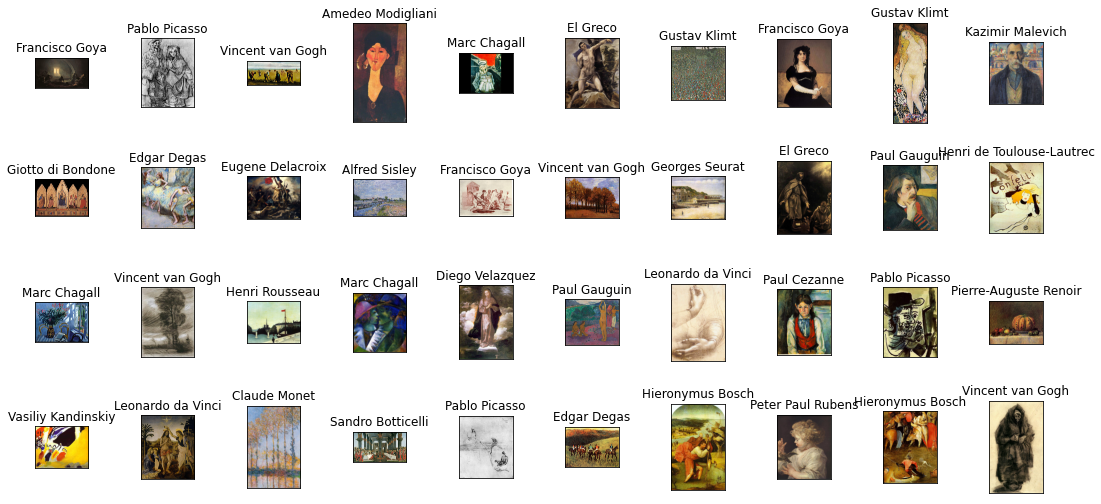

In [ ]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
artist_csv['artist'].iloc[0]

'Diego Velazquez'

In [ ]:
#각 라벨별 폴더 생성
for i in range(len(artist_csv['artist'])):
    nfolder = artist_csv['artist'].iloc[i]
    os.makedirs(nfolder, exist_ok=True)

In [ ]:
# tpath = '/content/'+ 'train/0000.jpg'
# testi = df['Filepath'] == tpath
# test = df[testi]
# a= test['Label'].values
# # b = str(a)
# # test['Label'] == 'Diego Velazquez'
# # a = test.Label
# # a
# b = a.tolist()
# result = ''.join(s for s in b)
# print(result)

In [ ]:
#라벨별 이미지 분류
root1 = '/content/train'
for root, dirs, filenames in os.walk(root1):
    for filename in filenames:
        path = os.path.join(root, filename)
        image = cv2.imread(path)
        if image is None:
            print('ERROR', path)
            continue
        findlabel = df['Filepath'] == path
        addimage = df[findlabel]
        pathvalues = addimage['Label'].values.tolist()
        pathresult = ''.join(s for s in pathvalues)
        first, last = os.path.splitext(filename)
        new_path = os.path.join(pathresult, first + '.jpg')
        # print(pathresult)
        cv2.imwrite(new_path, image)

In [ ]:
from imutils import paths

search_dir = '/content/Newimage'

image_paths = sorted(
    list(paths.list_images(search_dir))
)

print(">>> image count =", len(image_paths))

>>> image count = 5911


In [ ]:
from tqdm import tqdm

image_dim = (224, 224, 3)

images = []
labels = []
for image_path in tqdm(image_paths):
    image = cv2.imread(image_path)

    image = cv2.resize(
        image, (image_dim[1], image_dim[0])
    )
    images.append(image)
    
    label = image_path.split(os.path.sep)[-2]
    labels.append([label])
    
    print(">>> images count =", len(images))

  0%|          | 3/5911 [00:00<03:57, 24.87it/s]

>>> images count = 1
>>> images count = 2
>>> images count = 3
>>> images count = 4
>>> images count = 5
>>> images count = 6
>>> images count = 7


  0%|          | 13/5911 [00:00<02:30, 39.08it/s]

>>> images count = 8
>>> images count = 9
>>> images count = 10
>>> images count = 11
>>> images count = 12
>>> images count = 13
>>> images count = 14
>>> images count = 15
>>> images count = 16
>>> images count = 17


  0%|          | 23/5911 [00:00<02:23, 40.94it/s]

>>> images count = 18
>>> images count = 19
>>> images count = 20
>>> images count = 21
>>> images count = 22
>>> images count = 23
>>> images count = 24
>>> images count = 25


  0%|          | 28/5911 [00:00<02:48, 34.88it/s]

>>> images count = 26
>>> images count = 27
>>> images count = 28
>>> images count = 29
>>> images count = 30


  1%|          | 32/5911 [00:00<02:48, 34.79it/s]

>>> images count = 31
>>> images count = 32


  1%|          | 38/5911 [00:01<02:35, 37.85it/s]

>>> images count = 33
>>> images count = 34
>>> images count = 35
>>> images count = 36
>>> images count = 37
>>> images count = 38
>>> images count = 39
>>> images count = 40
>>> images count = 41


  1%|          | 46/5911 [00:01<02:38, 36.96it/s]

>>> images count = 42
>>> images count = 43
>>> images count = 44
>>> images count = 45
>>> images count = 46
>>> images count = 47
>>> images count = 48
>>> images count = 49


  1%|          | 55/5911 [00:01<02:31, 38.59it/s]

>>> images count = 50
>>> images count = 51
>>> images count = 52
>>> images count = 53
>>> images count = 54
>>> images count = 55
>>> images count = 56
>>> images count = 57
>>> images count = 58


  1%|          | 60/5911 [00:01<02:35, 37.66it/s]

>>> images count = 59
>>> images count = 60
>>> images count = 61
>>> images count = 62
>>> images count = 63


  1%|          | 65/5911 [00:01<02:31, 38.55it/s]

>>> images count = 64
>>> images count = 65
>>> images count = 66


  1%|          | 69/5911 [00:01<02:45, 35.26it/s]

>>> images count = 67
>>> images count = 68
>>> images count = 69


  1%|          | 73/5911 [00:01<02:40, 36.40it/s]

>>> images count = 70
>>> images count = 71
>>> images count = 72
>>> images count = 73


  1%|▏         | 80/5911 [00:02<02:10, 44.60it/s]

>>> images count = 74
>>> images count = 75
>>> images count = 76
>>> images count = 77
>>> images count = 78
>>> images count = 79
>>> images count = 80
>>> images count = 81
>>> images count = 82
>>> images count = 83
>>> images count = 84


  1%|▏         | 85/5911 [00:02<02:18, 42.00it/s]

>>> images count = 85
>>> images count = 86
>>> images count = 87
>>> images count = 88
>>> images count = 89
>>> images count = 90
>>> images count = 91


  2%|▏         | 92/5911 [00:02<02:00, 48.29it/s]

>>> images count = 92
>>> images count = 93
>>> images count = 94
>>> images count = 95
>>> images count = 96


  2%|▏         | 97/5911 [00:02<02:06, 46.06it/s]

>>> images count = 97
>>> images count = 98
>>> images count = 99
>>> images count = 100
>>> images count = 101
>>> images count = 102


  2%|▏         | 103/5911 [00:02<01:59, 48.44it/s]

>>> images count = 103
>>> images count = 104
>>> images count = 105
>>> images count = 106
>>> images count = 107


  2%|▏         | 108/5911 [00:02<02:05, 46.25it/s]

>>> images count = 108
>>> images count = 109
>>> images count = 110
>>> images count = 111


  2%|▏         | 114/5911 [00:02<02:04, 46.47it/s]

>>> images count = 112
>>> images count = 113
>>> images count = 114
>>> images count = 115
>>> images count = 116
>>> images count = 117
>>> images count = 118
>>> images count = 119


  2%|▏         | 122/5911 [00:02<01:50, 52.52it/s]

>>> images count = 120
>>> images count = 121
>>> images count = 122


  2%|▏         | 128/5911 [00:03<02:01, 47.52it/s]

>>> images count = 123
>>> images count = 124
>>> images count = 125
>>> images count = 126
>>> images count = 127
>>> images count = 128
>>> images count = 129
>>> images count = 130


  2%|▏         | 133/5911 [00:03<02:16, 42.33it/s]

>>> images count = 131
>>> images count = 132
>>> images count = 133
>>> images count = 134
>>> images count = 135
>>> images count = 136
>>> images count = 137


  2%|▏         | 138/5911 [00:03<02:15, 42.48it/s]

>>> images count = 138
>>> images count = 139
>>> images count = 140
>>> images count = 141


  2%|▏         | 143/5911 [00:03<02:13, 43.05it/s]

>>> images count = 142
>>> images count = 143
>>> images count = 144


  3%|▎         | 148/5911 [00:03<02:21, 40.80it/s]

>>> images count = 145
>>> images count = 146
>>> images count = 147
>>> images count = 148


  3%|▎         | 154/5911 [00:03<02:08, 44.94it/s]

>>> images count = 149
>>> images count = 150
>>> images count = 151
>>> images count = 152
>>> images count = 153
>>> images count = 154
>>> images count = 155
>>> images count = 156
>>> images count = 157
>>> images count = 158


  3%|▎         | 159/5911 [00:03<02:16, 42.09it/s]

>>> images count = 159
>>> images count = 160
>>> images count = 161
>>> images count = 162
>>> images count = 163


  3%|▎         | 164/5911 [00:04<02:37, 36.60it/s]

>>> images count = 164
>>> images count = 165


  3%|▎         | 169/5911 [00:04<02:26, 39.09it/s]

>>> images count = 166
>>> images count = 167
>>> images count = 168
>>> images count = 169
>>> images count = 170
>>> images count = 171


  3%|▎         | 174/5911 [00:04<02:30, 38.02it/s]

>>> images count = 172
>>> images count = 173
>>> images count = 174


  3%|▎         | 181/5911 [00:04<02:16, 41.88it/s]

>>> images count = 175
>>> images count = 176
>>> images count = 177
>>> images count = 178
>>> images count = 179
>>> images count = 180
>>> images count = 181
>>> images count = 182
>>> images count = 183
>>> images count = 184


  3%|▎         | 186/5911 [00:04<02:18, 41.28it/s]

>>> images count = 185
>>> images count = 186
>>> images count = 187
>>> images count = 188
>>> images count = 189
>>> images count = 190
>>> images count = 191


  3%|▎         | 192/5911 [00:04<02:21, 40.49it/s]

>>> images count = 192


  3%|▎         | 197/5911 [00:04<02:36, 36.48it/s]

>>> images count = 193
>>> images count = 194
>>> images count = 195
>>> images count = 196
>>> images count = 197
>>> images count = 198
>>> images count = 199
>>> images count = 200
>>> images count = 201


  3%|▎         | 202/5911 [00:04<02:31, 37.61it/s]

>>> images count = 202
>>> images count = 203
>>> images count = 204
>>> images count = 205
>>> images count = 206


  4%|▎         | 207/5911 [00:05<02:32, 37.32it/s]

>>> images count = 207
>>> images count = 208
>>> images count = 209


  4%|▎         | 211/5911 [00:05<02:32, 37.28it/s]

>>> images count = 210
>>> images count = 211
>>> images count = 212
>>> images count = 213
>>> images count = 214
>>> images count = 215
>>> images count = 216


  4%|▎         | 217/5911 [00:05<02:13, 42.58it/s]

>>> images count = 217
>>> images count = 218


  4%|▍         | 222/5911 [00:05<02:21, 40.32it/s]

>>> images count = 219
>>> images count = 220
>>> images count = 221
>>> images count = 222
>>> images count = 223
>>> images count = 224


  4%|▍         | 228/5911 [00:05<02:08, 44.26it/s]

>>> images count = 225
>>> images count = 226
>>> images count = 227
>>> images count = 228
>>> images count = 229


  4%|▍         | 233/5911 [00:05<02:10, 43.57it/s]

>>> images count = 230
>>> images count = 231
>>> images count = 232
>>> images count = 233
>>> images count = 234
>>> images count = 235
>>> images count = 236


  4%|▍         | 243/5911 [00:05<02:16, 41.51it/s]

>>> images count = 237
>>> images count = 238
>>> images count = 239
>>> images count = 240
>>> images count = 241
>>> images count = 242
>>> images count = 243
>>> images count = 244
>>> images count = 245
>>> images count = 246


  4%|▍         | 249/5911 [00:06<02:17, 41.11it/s]

>>> images count = 247
>>> images count = 248
>>> images count = 249
>>> images count = 250
>>> images count = 251
>>> images count = 252


  4%|▍         | 256/5911 [00:06<02:02, 46.14it/s]

>>> images count = 253
>>> images count = 254
>>> images count = 255
>>> images count = 256
>>> images count = 257


  4%|▍         | 262/5911 [00:06<02:00, 46.80it/s]

>>> images count = 258
>>> images count = 259
>>> images count = 260
>>> images count = 261
>>> images count = 262
>>> images count = 263
>>> images count = 264
>>> images count = 265
>>> images count = 266
>>> images count = 267


  5%|▍         | 268/5911 [00:06<02:01, 46.60it/s]

>>> images count = 268
>>> images count = 269
>>> images count = 270
>>> images count = 271
>>> images count = 272
>>> images count = 273


  5%|▍         | 274/5911 [00:06<01:54, 49.08it/s]

>>> images count = 274
>>> images count = 275
>>> images count = 276
>>> images count = 277
>>> images count = 278


  5%|▍         | 279/5911 [00:06<01:56, 48.23it/s]

>>> images count = 279
>>> images count = 280


  5%|▍         | 284/5911 [00:06<02:09, 43.56it/s]

>>> images count = 281
>>> images count = 282
>>> images count = 283
>>> images count = 284
>>> images count = 285
>>> images count = 286
>>> images count = 287


  5%|▍         | 289/5911 [00:06<02:10, 42.94it/s]

>>> images count = 288
>>> images count = 289
>>> images count = 290


  5%|▍         | 294/5911 [00:07<02:15, 41.59it/s]

>>> images count = 291
>>> images count = 292
>>> images count = 293
>>> images count = 294
>>> images count = 295
>>> images count = 296


  5%|▌         | 300/5911 [00:07<02:10, 43.16it/s]

>>> images count = 297
>>> images count = 298
>>> images count = 299
>>> images count = 300


  5%|▌         | 305/5911 [00:07<02:08, 43.46it/s]

>>> images count = 301
>>> images count = 302
>>> images count = 303
>>> images count = 304
>>> images count = 305
>>> images count = 306
>>> images count = 307
>>> images count = 308
>>> images count = 309
>>> images count = 310
>>> images count = 311


  5%|▌         | 312/5911 [00:07<02:04, 45.03it/s]

>>> images count = 312
>>> images count = 313
>>> images count = 314
>>> images count = 315
>>> images count = 316
>>> images count = 317
>>> images count = 318


  5%|▌         | 320/5911 [00:07<01:56, 48.05it/s]

>>> images count = 319
>>> images count = 320
>>> images count = 321


  5%|▌         | 325/5911 [00:07<01:58, 47.13it/s]

>>> images count = 322
>>> images count = 323
>>> images count = 324
>>> images count = 325
>>> images count = 326
>>> images count = 327


  6%|▌         | 332/5911 [00:07<01:48, 51.26it/s]

>>> images count = 328
>>> images count = 329
>>> images count = 330
>>> images count = 331
>>> images count = 332
>>> images count = 333
>>> images count = 334


  6%|▌         | 338/5911 [00:07<01:51, 49.99it/s]

>>> images count = 335
>>> images count = 336
>>> images count = 337
>>> images count = 338
>>> images count = 339
>>> images count = 340
>>> images count = 341
>>> images count = 342
>>> images count = 343


  6%|▌         | 344/5911 [00:08<01:54, 48.69it/s]

>>> images count = 344
>>> images count = 345
>>> images count = 346
>>> images count = 347


  6%|▌         | 349/5911 [00:08<02:02, 45.29it/s]

>>> images count = 348
>>> images count = 349
>>> images count = 350
>>> images count = 351
>>> images count = 352
>>> images count = 353


  6%|▌         | 355/5911 [00:08<01:56, 47.58it/s]

>>> images count = 354
>>> images count = 355
>>> images count = 356
>>> images count = 357


  6%|▌         | 360/5911 [00:08<02:02, 45.30it/s]

>>> images count = 358
>>> images count = 359
>>> images count = 360
>>> images count = 361
>>> images count = 362


  6%|▌         | 366/5911 [00:08<01:59, 46.54it/s]

>>> images count = 363
>>> images count = 364
>>> images count = 365
>>> images count = 366
>>> images count = 367
>>> images count = 368
>>> images count = 369


  6%|▋         | 371/5911 [00:08<02:18, 40.11it/s]

>>> images count = 370
>>> images count = 371
>>> images count = 372
>>> images count = 373


  6%|▋         | 377/5911 [00:08<02:09, 42.62it/s]

>>> images count = 374
>>> images count = 375
>>> images count = 376
>>> images count = 377
>>> images count = 378
>>> images count = 379


  6%|▋         | 383/5911 [00:09<02:01, 45.52it/s]

>>> images count = 380
>>> images count = 381
>>> images count = 382
>>> images count = 383


  7%|▋         | 396/5911 [00:09<01:23, 66.38it/s]

>>> images count = 384
>>> images count = 385
>>> images count = 386
>>> images count = 387
>>> images count = 388
>>> images count = 389
>>> images count = 390
>>> images count = 391
>>> images count = 392
>>> images count = 393
>>> images count = 394
>>> images count = 395
>>> images count = 396
>>> images count = 397
>>> images count = 398
>>> images count = 399
>>> images count = 400
>>> images count = 401
>>> images count = 402
>>> images count = 403


  7%|▋         | 411/5911 [00:09<01:03, 87.09it/s]

>>> images count = 404
>>> images count = 405
>>> images count = 406
>>> images count = 407
>>> images count = 408
>>> images count = 409
>>> images count = 410
>>> images count = 411
>>> images count = 412


  7%|▋         | 425/5911 [00:09<00:54, 101.05it/s]

>>> images count = 413
>>> images count = 414
>>> images count = 415
>>> images count = 416
>>> images count = 417
>>> images count = 418
>>> images count = 419
>>> images count = 420
>>> images count = 421
>>> images count = 422
>>> images count = 423
>>> images count = 424
>>> images count = 425
>>> images count = 426
>>> images count = 427
>>> images count = 428
>>> images count = 429
>>> images count = 430
>>> images count = 431


  7%|▋         | 440/5911 [00:09<00:47, 114.60it/s]

>>> images count = 432
>>> images count = 433
>>> images count = 434
>>> images count = 435
>>> images count = 436
>>> images count = 437
>>> images count = 438
>>> images count = 439
>>> images count = 440
>>> images count = 441
>>> images count = 442
>>> images count = 443


  8%|▊         | 455/5911 [00:09<00:44, 122.84it/s]

>>> images count = 444
>>> images count = 445
>>> images count = 446
>>> images count = 447
>>> images count = 448
>>> images count = 449
>>> images count = 450
>>> images count = 451
>>> images count = 452
>>> images count = 453
>>> images count = 454
>>> images count = 455
>>> images count = 456
>>> images count = 457
>>> images count = 458
>>> images count = 459
>>> images count = 460
>>> images count = 461


  8%|▊         | 469/5911 [00:09<00:42, 126.81it/s]

>>> images count = 462
>>> images count = 463
>>> images count = 464
>>> images count = 465
>>> images count = 466
>>> images count = 467
>>> images count = 468
>>> images count = 469
>>> images count = 470
>>> images count = 471


  8%|▊         | 483/5911 [00:09<00:41, 129.60it/s]

>>> images count = 472
>>> images count = 473
>>> images count = 474
>>> images count = 475
>>> images count = 476
>>> images count = 477
>>> images count = 478
>>> images count = 479
>>> images count = 480
>>> images count = 481
>>> images count = 482
>>> images count = 483
>>> images count = 484
>>> images count = 485
>>> images count = 486
>>> images count = 487
>>> images count = 488
>>> images count = 489


  8%|▊         | 499/5911 [00:09<00:39, 137.20it/s]

>>> images count = 490
>>> images count = 491
>>> images count = 492
>>> images count = 493
>>> images count = 494
>>> images count = 495
>>> images count = 496
>>> images count = 497
>>> images count = 498
>>> images count = 499
>>> images count = 500
>>> images count = 501


  9%|▊         | 513/5911 [00:09<00:39, 137.15it/s]

>>> images count = 502
>>> images count = 503
>>> images count = 504
>>> images count = 505
>>> images count = 506
>>> images count = 507
>>> images count = 508
>>> images count = 509
>>> images count = 510
>>> images count = 511
>>> images count = 512
>>> images count = 513
>>> images count = 514
>>> images count = 515
>>> images count = 516
>>> images count = 517
>>> images count = 518
>>> images count = 519
>>> images count = 520
>>> images count = 521
>>> images count = 522
>>> images count = 523
>>> images count = 524


  9%|▉         | 527/5911 [00:10<00:44, 120.06it/s]

>>> images count = 525
>>> images count = 526
>>> images count = 527
>>> images count = 528
>>> images count = 529
>>> images count = 530
>>> images count = 531
>>> images count = 532
>>> images count = 533
>>> images count = 534
>>> images count = 535


  9%|▉         | 540/5911 [00:10<00:49, 109.08it/s]

>>> images count = 536
>>> images count = 537
>>> images count = 538
>>> images count = 539
>>> images count = 540
>>> images count = 541
>>> images count = 542


  9%|▉         | 552/5911 [00:10<00:54, 98.59it/s] 

>>> images count = 543
>>> images count = 544
>>> images count = 545
>>> images count = 546
>>> images count = 547
>>> images count = 548
>>> images count = 549
>>> images count = 550
>>> images count = 551
>>> images count = 552
>>> images count = 553
>>> images count = 554
>>> images count = 555
>>> images count = 556
>>> images count = 557


 10%|▉         | 563/5911 [00:10<01:01, 86.39it/s]

>>> images count = 558
>>> images count = 559
>>> images count = 560
>>> images count = 561
>>> images count = 562
>>> images count = 563
>>> images count = 564
>>> images count = 565


 10%|▉         | 573/5911 [00:10<01:02, 85.16it/s]

>>> images count = 566
>>> images count = 567
>>> images count = 568
>>> images count = 569
>>> images count = 570
>>> images count = 571
>>> images count = 572
>>> images count = 573


 10%|▉         | 585/5911 [00:10<00:58, 91.22it/s]

>>> images count = 574
>>> images count = 575
>>> images count = 576
>>> images count = 577
>>> images count = 578
>>> images count = 579
>>> images count = 580
>>> images count = 581
>>> images count = 582
>>> images count = 583
>>> images count = 584
>>> images count = 585


 10%|█         | 601/5911 [00:10<00:49, 107.64it/s]

>>> images count = 586
>>> images count = 587
>>> images count = 588
>>> images count = 589
>>> images count = 590
>>> images count = 591
>>> images count = 592
>>> images count = 593
>>> images count = 594
>>> images count = 595
>>> images count = 596
>>> images count = 597
>>> images count = 598
>>> images count = 599
>>> images count = 600
>>> images count = 601


 11%|█         | 624/5911 [00:11<00:38, 137.91it/s]

>>> images count = 602
>>> images count = 603
>>> images count = 604
>>> images count = 605
>>> images count = 606
>>> images count = 607
>>> images count = 608
>>> images count = 609
>>> images count = 610
>>> images count = 611
>>> images count = 612
>>> images count = 613
>>> images count = 614
>>> images count = 615
>>> images count = 616
>>> images count = 617
>>> images count = 618
>>> images count = 619
>>> images count = 620
>>> images count = 621
>>> images count = 622
>>> images count = 623
>>> images count = 624
>>> images count = 625


 11%|█         | 646/5911 [00:11<00:33, 159.30it/s]

>>> images count = 626
>>> images count = 627
>>> images count = 628
>>> images count = 629
>>> images count = 630
>>> images count = 631
>>> images count = 632
>>> images count = 633
>>> images count = 634
>>> images count = 635
>>> images count = 636
>>> images count = 637
>>> images count = 638
>>> images count = 639
>>> images count = 640
>>> images count = 641
>>> images count = 642
>>> images count = 643
>>> images count = 644
>>> images count = 645
>>> images count = 646


 11%|█▏        | 668/5911 [00:11<00:29, 175.30it/s]

>>> images count = 647
>>> images count = 648
>>> images count = 649
>>> images count = 650
>>> images count = 651
>>> images count = 652
>>> images count = 653
>>> images count = 654
>>> images count = 655
>>> images count = 656
>>> images count = 657
>>> images count = 658
>>> images count = 659
>>> images count = 660
>>> images count = 661
>>> images count = 662
>>> images count = 663
>>> images count = 664
>>> images count = 665
>>> images count = 666
>>> images count = 667
>>> images count = 668
>>> images count = 669


 12%|█▏        | 689/5911 [00:11<00:28, 182.52it/s]

>>> images count = 670
>>> images count = 671
>>> images count = 672
>>> images count = 673
>>> images count = 674
>>> images count = 675
>>> images count = 676
>>> images count = 677
>>> images count = 678
>>> images count = 679
>>> images count = 680
>>> images count = 681
>>> images count = 682
>>> images count = 683
>>> images count = 684
>>> images count = 685
>>> images count = 686
>>> images count = 687
>>> images count = 688
>>> images count = 689
>>> images count = 690


 12%|█▏        | 708/5911 [00:11<00:28, 184.22it/s]

>>> images count = 691
>>> images count = 692
>>> images count = 693
>>> images count = 694
>>> images count = 695
>>> images count = 696
>>> images count = 697
>>> images count = 698
>>> images count = 699
>>> images count = 700
>>> images count = 701
>>> images count = 702
>>> images count = 703
>>> images count = 704
>>> images count = 705
>>> images count = 706
>>> images count = 707
>>> images count = 708
>>> images count = 709
>>> images count = 710
>>> images count = 711
>>> images count = 712
>>> images count = 713
>>> images count = 714
>>> images count = 715
>>> images count = 716
>>> images count = 717
>>> images count = 718
>>> images count = 719
>>> images count = 720
>>> images count = 721
>>> images count = 722
>>> images count = 723
>>> images count = 724
>>> images count = 725


 12%|█▏        | 727/5911 [00:11<00:30, 169.54it/s]

>>> images count = 726
>>> images count = 727
>>> images count = 728
>>> images count = 729
>>> images count = 730
>>> images count = 731
>>> images count = 732
>>> images count = 733
>>> images count = 734
>>> images count = 735
>>> images count = 736
>>> images count = 737
>>> images count = 738


 13%|█▎        | 745/5911 [00:11<00:43, 118.70it/s]

>>> images count = 739
>>> images count = 740
>>> images count = 741
>>> images count = 742
>>> images count = 743
>>> images count = 744
>>> images count = 745
>>> images count = 746
>>> images count = 747
>>> images count = 748
>>> images count = 749
>>> images count = 750
>>> images count = 751
>>> images count = 752


 13%|█▎        | 760/5911 [00:12<00:51, 99.76it/s] 

>>> images count = 753
>>> images count = 754
>>> images count = 755
>>> images count = 756
>>> images count = 757
>>> images count = 758
>>> images count = 759
>>> images count = 760
>>> images count = 761
>>> images count = 762
>>> images count = 763
>>> images count = 764
>>> images count = 765
>>> images count = 766
>>> images count = 767


 13%|█▎        | 772/5911 [00:12<00:54, 93.79it/s]

>>> images count = 768
>>> images count = 769
>>> images count = 770
>>> images count = 771
>>> images count = 772
>>> images count = 773
>>> images count = 774
>>> images count = 775
>>> images count = 776
>>> images count = 777
>>> images count = 778
>>> images count = 779
>>> images count = 780
>>> images count = 781


 13%|█▎        | 783/5911 [00:12<01:00, 84.93it/s]

>>> images count = 782
>>> images count = 783
>>> images count = 784
>>> images count = 785
>>> images count = 786
>>> images count = 787
>>> images count = 788
>>> images count = 789
>>> images count = 790
>>> images count = 791


 13%|█▎        | 793/5911 [00:12<01:14, 68.61it/s]

>>> images count = 792
>>> images count = 793
>>> images count = 794
>>> images count = 795
>>> images count = 796
>>> images count = 797
>>> images count = 798


 14%|█▎        | 801/5911 [00:12<01:34, 54.14it/s]

>>> images count = 799
>>> images count = 800
>>> images count = 801
>>> images count = 802
>>> images count = 803


 14%|█▎        | 808/5911 [00:13<01:44, 48.81it/s]

>>> images count = 804
>>> images count = 805
>>> images count = 806
>>> images count = 807
>>> images count = 808
>>> images count = 809
>>> images count = 810
>>> images count = 811


 14%|█▍        | 814/5911 [00:13<01:48, 47.08it/s]

>>> images count = 812
>>> images count = 813
>>> images count = 814


 14%|█▍        | 820/5911 [00:13<01:47, 47.45it/s]

>>> images count = 815
>>> images count = 816
>>> images count = 817
>>> images count = 818
>>> images count = 819
>>> images count = 820
>>> images count = 821
>>> images count = 822


 14%|█▍        | 826/5911 [00:13<01:52, 45.29it/s]

>>> images count = 823
>>> images count = 824
>>> images count = 825
>>> images count = 826
>>> images count = 827
>>> images count = 828
>>> images count = 829
>>> images count = 830
>>> images count = 831
>>> images count = 832


 14%|█▍        | 833/5911 [00:13<01:46, 47.47it/s]

>>> images count = 833


 14%|█▍        | 838/5911 [00:13<01:45, 48.00it/s]

>>> images count = 834
>>> images count = 835
>>> images count = 836
>>> images count = 837
>>> images count = 838
>>> images count = 839
>>> images count = 840
>>> images count = 841
>>> images count = 842


 14%|█▍        | 843/5911 [00:13<01:55, 43.75it/s]

>>> images count = 843


 14%|█▍        | 848/5911 [00:13<01:53, 44.46it/s]

>>> images count = 844
>>> images count = 845
>>> images count = 846
>>> images count = 847
>>> images count = 848
>>> images count = 849
>>> images count = 850
>>> images count = 851
>>> images count = 852


 15%|█▍        | 859/5911 [00:14<01:52, 45.09it/s]

>>> images count = 853
>>> images count = 854
>>> images count = 855
>>> images count = 856
>>> images count = 857
>>> images count = 858
>>> images count = 859
>>> images count = 860
>>> images count = 861
>>> images count = 862


 15%|█▍        | 869/5911 [00:14<02:06, 39.80it/s]

>>> images count = 863
>>> images count = 864
>>> images count = 865
>>> images count = 866
>>> images count = 867
>>> images count = 868
>>> images count = 869


 15%|█▍        | 874/5911 [00:14<02:09, 39.03it/s]

>>> images count = 870
>>> images count = 871
>>> images count = 872
>>> images count = 873
>>> images count = 874
>>> images count = 875
>>> images count = 876


 15%|█▌        | 893/5911 [00:14<01:21, 61.21it/s]

>>> images count = 877
>>> images count = 878
>>> images count = 879
>>> images count = 880
>>> images count = 881
>>> images count = 882
>>> images count = 883
>>> images count = 884
>>> images count = 885
>>> images count = 886
>>> images count = 887
>>> images count = 888
>>> images count = 889
>>> images count = 890
>>> images count = 891
>>> images count = 892
>>> images count = 893
>>> images count = 894
>>> images count = 895
>>> images count = 896
>>> images count = 897
>>> images count = 898
>>> images count = 899
>>> images count = 900
>>> images count = 901
>>> images count = 902


 16%|█▌        | 920/5911 [00:15<00:54, 91.95it/s]

>>> images count = 903
>>> images count = 904
>>> images count = 905
>>> images count = 906
>>> images count = 907
>>> images count = 908
>>> images count = 909
>>> images count = 910
>>> images count = 911
>>> images count = 912
>>> images count = 913
>>> images count = 914
>>> images count = 915
>>> images count = 916
>>> images count = 917
>>> images count = 918
>>> images count = 919
>>> images count = 920
>>> images count = 921
>>> images count = 922
>>> images count = 923
>>> images count = 924
>>> images count = 925
>>> images count = 926
>>> images count = 927


 16%|█▌        | 941/5911 [00:15<00:56, 87.80it/s]

>>> images count = 928
>>> images count = 929
>>> images count = 930
>>> images count = 931
>>> images count = 932
>>> images count = 933
>>> images count = 934
>>> images count = 935
>>> images count = 936
>>> images count = 937
>>> images count = 938
>>> images count = 939
>>> images count = 940
>>> images count = 941
>>> images count = 942
>>> images count = 943
>>> images count = 944


 16%|█▋        | 961/5911 [00:15<00:56, 87.98it/s]

>>> images count = 945
>>> images count = 946
>>> images count = 947
>>> images count = 948
>>> images count = 949
>>> images count = 950
>>> images count = 951
>>> images count = 952
>>> images count = 953
>>> images count = 954
>>> images count = 955
>>> images count = 956
>>> images count = 957
>>> images count = 958
>>> images count = 959
>>> images count = 960
>>> images count = 961


 16%|█▋        | 971/5911 [00:15<00:57, 86.45it/s]

>>> images count = 962
>>> images count = 963
>>> images count = 964
>>> images count = 965
>>> images count = 966
>>> images count = 967
>>> images count = 968
>>> images count = 969
>>> images count = 970
>>> images count = 971
>>> images count = 972
>>> images count = 973
>>> images count = 974
>>> images count = 975
>>> images count = 976
>>> images count = 977
>>> images count = 978
>>> images count = 979


 17%|█▋        | 992/5911 [00:15<00:53, 92.21it/s]

>>> images count = 980
>>> images count = 981
>>> images count = 982
>>> images count = 983
>>> images count = 984
>>> images count = 985
>>> images count = 986
>>> images count = 987
>>> images count = 988
>>> images count = 989
>>> images count = 990
>>> images count = 991
>>> images count = 992
>>> images count = 993
>>> images count = 994
>>> images count = 995
>>> images count = 996
>>> images count = 997
>>> images count = 998


 17%|█▋        | 1012/5911 [00:16<00:55, 88.23it/s]

>>> images count = 999
>>> images count = 1000
>>> images count = 1001
>>> images count = 1002
>>> images count = 1003
>>> images count = 1004
>>> images count = 1005
>>> images count = 1006
>>> images count = 1007
>>> images count = 1008
>>> images count = 1009
>>> images count = 1010
>>> images count = 1011
>>> images count = 1012
>>> images count = 1013
>>> images count = 1014
>>> images count = 1015


 17%|█▋        | 1021/5911 [00:16<01:00, 81.20it/s]

>>> images count = 1016
>>> images count = 1017
>>> images count = 1018
>>> images count = 1019
>>> images count = 1020
>>> images count = 1021
>>> images count = 1022
>>> images count = 1023
>>> images count = 1024
>>> images count = 1025
>>> images count = 1026
>>> images count = 1027


 17%|█▋        | 1030/5911 [00:16<01:06, 73.87it/s]

>>> images count = 1028
>>> images count = 1029
>>> images count = 1030
>>> images count = 1031
>>> images count = 1032
>>> images count = 1033
>>> images count = 1034


 18%|█▊        | 1045/5911 [00:16<01:24, 57.72it/s]

>>> images count = 1035
>>> images count = 1036
>>> images count = 1037
>>> images count = 1038
>>> images count = 1039
>>> images count = 1040
>>> images count = 1041
>>> images count = 1042
>>> images count = 1043
>>> images count = 1044
>>> images count = 1045
>>> images count = 1046
>>> images count = 1047


 18%|█▊        | 1060/5911 [00:17<01:21, 59.74it/s]

>>> images count = 1048
>>> images count = 1049
>>> images count = 1050
>>> images count = 1051
>>> images count = 1052
>>> images count = 1053
>>> images count = 1054
>>> images count = 1055
>>> images count = 1056
>>> images count = 1057
>>> images count = 1058
>>> images count = 1059
>>> images count = 1060


 18%|█▊        | 1067/5911 [00:17<01:23, 58.09it/s]

>>> images count = 1061
>>> images count = 1062
>>> images count = 1063
>>> images count = 1064
>>> images count = 1065
>>> images count = 1066
>>> images count = 1067
>>> images count = 1068
>>> images count = 1069
>>> images count = 1070
>>> images count = 1071
>>> images count = 1072


 18%|█▊        | 1081/5911 [00:17<01:16, 63.01it/s]

>>> images count = 1073
>>> images count = 1074
>>> images count = 1075
>>> images count = 1076
>>> images count = 1077
>>> images count = 1078
>>> images count = 1079
>>> images count = 1080
>>> images count = 1081
>>> images count = 1082
>>> images count = 1083
>>> images count = 1084
>>> images count = 1085


 19%|█▊        | 1097/5911 [00:17<01:14, 64.65it/s]

>>> images count = 1086
>>> images count = 1087
>>> images count = 1088
>>> images count = 1089
>>> images count = 1090
>>> images count = 1091
>>> images count = 1092
>>> images count = 1093
>>> images count = 1094
>>> images count = 1095
>>> images count = 1096
>>> images count = 1097


 19%|█▊        | 1104/5911 [00:17<01:31, 52.65it/s]

>>> images count = 1098
>>> images count = 1099
>>> images count = 1100
>>> images count = 1101
>>> images count = 1102
>>> images count = 1103
>>> images count = 1104
>>> images count = 1105
>>> images count = 1106
>>> images count = 1107
>>> images count = 1108


 19%|█▉        | 1117/5911 [00:18<01:26, 55.69it/s]

>>> images count = 1109
>>> images count = 1110
>>> images count = 1111
>>> images count = 1112
>>> images count = 1113
>>> images count = 1114
>>> images count = 1115
>>> images count = 1116
>>> images count = 1117
>>> images count = 1118
>>> images count = 1119
>>> images count = 1120
>>> images count = 1121
>>> images count = 1122


 19%|█▉        | 1131/5911 [00:18<01:24, 56.26it/s]

>>> images count = 1123
>>> images count = 1124
>>> images count = 1125
>>> images count = 1126
>>> images count = 1127
>>> images count = 1128
>>> images count = 1129
>>> images count = 1130
>>> images count = 1131
>>> images count = 1132
>>> images count = 1133


 19%|█▉        | 1145/5911 [00:18<01:17, 61.54it/s]

>>> images count = 1134
>>> images count = 1135
>>> images count = 1136
>>> images count = 1137
>>> images count = 1138
>>> images count = 1139
>>> images count = 1140
>>> images count = 1141
>>> images count = 1142
>>> images count = 1143
>>> images count = 1144
>>> images count = 1145
>>> images count = 1146


 19%|█▉        | 1152/5911 [00:18<01:15, 63.07it/s]

>>> images count = 1147
>>> images count = 1148
>>> images count = 1149
>>> images count = 1150
>>> images count = 1151
>>> images count = 1152
>>> images count = 1153
>>> images count = 1154
>>> images count = 1155
>>> images count = 1156
>>> images count = 1157
>>> images count = 1158


 20%|█▉        | 1165/5911 [00:18<01:22, 57.28it/s]

>>> images count = 1159
>>> images count = 1160
>>> images count = 1161
>>> images count = 1162
>>> images count = 1163
>>> images count = 1164
>>> images count = 1165
>>> images count = 1166
>>> images count = 1167
>>> images count = 1168
>>> images count = 1169
>>> images count = 1170
>>> images count = 1171
>>> images count = 1172


 20%|█▉        | 1181/5911 [00:19<01:17, 61.11it/s]

>>> images count = 1173
>>> images count = 1174
>>> images count = 1175
>>> images count = 1176
>>> images count = 1177
>>> images count = 1178
>>> images count = 1179
>>> images count = 1180
>>> images count = 1181
>>> images count = 1182
>>> images count = 1183
>>> images count = 1184
>>> images count = 1185


 20%|██        | 1197/5911 [00:19<01:12, 65.18it/s]

>>> images count = 1186
>>> images count = 1187
>>> images count = 1188
>>> images count = 1189
>>> images count = 1190
>>> images count = 1191
>>> images count = 1192
>>> images count = 1193
>>> images count = 1194
>>> images count = 1195
>>> images count = 1196
>>> images count = 1197
>>> images count = 1198


 20%|██        | 1204/5911 [00:19<01:21, 57.81it/s]

>>> images count = 1199
>>> images count = 1200
>>> images count = 1201
>>> images count = 1202
>>> images count = 1203
>>> images count = 1204
>>> images count = 1205
>>> images count = 1206
>>> images count = 1207
>>> images count = 1208
>>> images count = 1209
>>> images count = 1210
>>> images count = 1211


 21%|██        | 1220/5911 [00:19<01:11, 65.81it/s]

>>> images count = 1212
>>> images count = 1213
>>> images count = 1214
>>> images count = 1215
>>> images count = 1216
>>> images count = 1217
>>> images count = 1218
>>> images count = 1219
>>> images count = 1220
>>> images count = 1221
>>> images count = 1222
>>> images count = 1223
>>> images count = 1224
>>> images count = 1225


 21%|██        | 1234/5911 [00:19<01:22, 56.60it/s]

>>> images count = 1226
>>> images count = 1227
>>> images count = 1228
>>> images count = 1229
>>> images count = 1230
>>> images count = 1231
>>> images count = 1232
>>> images count = 1233
>>> images count = 1234
>>> images count = 1235


 21%|██        | 1247/5911 [00:20<01:20, 57.77it/s]

>>> images count = 1236
>>> images count = 1237
>>> images count = 1238
>>> images count = 1239
>>> images count = 1240
>>> images count = 1241
>>> images count = 1242
>>> images count = 1243
>>> images count = 1244
>>> images count = 1245
>>> images count = 1246
>>> images count = 1247


 21%|██▏       | 1259/5911 [00:20<01:32, 50.15it/s]

>>> images count = 1248
>>> images count = 1249
>>> images count = 1250
>>> images count = 1251
>>> images count = 1252
>>> images count = 1253
>>> images count = 1254
>>> images count = 1255
>>> images count = 1256
>>> images count = 1257
>>> images count = 1258
>>> images count = 1259


 21%|██▏       | 1268/5911 [00:20<01:26, 53.78it/s]

>>> images count = 1260
>>> images count = 1261
>>> images count = 1262
>>> images count = 1263
>>> images count = 1264
>>> images count = 1265
>>> images count = 1266
>>> images count = 1267
>>> images count = 1268
>>> images count = 1269
>>> images count = 1270
>>> images count = 1271
>>> images count = 1272
>>> images count = 1273


 22%|██▏       | 1283/5911 [00:20<01:16, 60.30it/s]

>>> images count = 1274
>>> images count = 1275
>>> images count = 1276
>>> images count = 1277
>>> images count = 1278
>>> images count = 1279
>>> images count = 1280
>>> images count = 1281
>>> images count = 1282
>>> images count = 1283
>>> images count = 1284
>>> images count = 1285
>>> images count = 1286
>>> images count = 1287


 22%|██▏       | 1291/5911 [00:20<01:19, 58.09it/s]

>>> images count = 1288
>>> images count = 1289
>>> images count = 1290
>>> images count = 1291
>>> images count = 1292


 22%|██▏       | 1303/5911 [00:21<01:35, 48.11it/s]

>>> images count = 1293
>>> images count = 1294
>>> images count = 1295
>>> images count = 1296
>>> images count = 1297
>>> images count = 1298
>>> images count = 1299
>>> images count = 1300
>>> images count = 1301
>>> images count = 1302
>>> images count = 1303


 22%|██▏       | 1309/5911 [00:21<01:31, 50.12it/s]

>>> images count = 1304
>>> images count = 1305
>>> images count = 1306
>>> images count = 1307
>>> images count = 1308
>>> images count = 1309
>>> images count = 1310
>>> images count = 1311
>>> images count = 1312
>>> images count = 1313
>>> images count = 1314


 22%|██▏       | 1322/5911 [00:21<01:24, 54.02it/s]

>>> images count = 1315
>>> images count = 1316
>>> images count = 1317
>>> images count = 1318
>>> images count = 1319
>>> images count = 1320
>>> images count = 1321
>>> images count = 1322
>>> images count = 1323
>>> images count = 1324
>>> images count = 1325
>>> images count = 1326
>>> images count = 1327


 23%|██▎       | 1335/5911 [00:21<01:23, 54.96it/s]

>>> images count = 1328
>>> images count = 1329
>>> images count = 1330
>>> images count = 1331
>>> images count = 1332
>>> images count = 1333
>>> images count = 1334
>>> images count = 1335
>>> images count = 1336
>>> images count = 1337
>>> images count = 1338


 23%|██▎       | 1348/5911 [00:22<01:26, 52.73it/s]

>>> images count = 1339
>>> images count = 1340
>>> images count = 1341
>>> images count = 1342
>>> images count = 1343
>>> images count = 1344
>>> images count = 1345
>>> images count = 1346
>>> images count = 1347
>>> images count = 1348
>>> images count = 1349


 23%|██▎       | 1355/5911 [00:22<01:21, 55.78it/s]

>>> images count = 1350
>>> images count = 1351
>>> images count = 1352
>>> images count = 1353
>>> images count = 1354
>>> images count = 1355
>>> images count = 1356
>>> images count = 1357
>>> images count = 1358


 23%|██▎       | 1366/5911 [00:22<01:48, 41.70it/s]

>>> images count = 1359
>>> images count = 1360
>>> images count = 1361
>>> images count = 1362
>>> images count = 1363
>>> images count = 1364
>>> images count = 1365
>>> images count = 1366


 23%|██▎       | 1371/5911 [00:22<01:53, 40.09it/s]

>>> images count = 1367
>>> images count = 1368
>>> images count = 1369
>>> images count = 1370
>>> images count = 1371
>>> images count = 1372
>>> images count = 1373
>>> images count = 1374


 23%|██▎       | 1385/5911 [00:22<01:32, 48.70it/s]

>>> images count = 1375
>>> images count = 1376
>>> images count = 1377
>>> images count = 1378
>>> images count = 1379
>>> images count = 1380
>>> images count = 1381
>>> images count = 1382
>>> images count = 1383
>>> images count = 1384
>>> images count = 1385
>>> images count = 1386
>>> images count = 1387


 24%|██▎       | 1391/5911 [00:23<01:29, 50.36it/s]

>>> images count = 1388
>>> images count = 1389
>>> images count = 1390
>>> images count = 1391
>>> images count = 1392
>>> images count = 1393
>>> images count = 1394
>>> images count = 1395


 24%|██▍       | 1405/5911 [00:23<01:28, 51.05it/s]

>>> images count = 1396
>>> images count = 1397
>>> images count = 1398
>>> images count = 1399
>>> images count = 1400
>>> images count = 1401
>>> images count = 1402
>>> images count = 1403
>>> images count = 1404
>>> images count = 1405
>>> images count = 1406
>>> images count = 1407
>>> images count = 1408


 24%|██▍       | 1419/5911 [00:23<01:16, 58.90it/s]

>>> images count = 1409
>>> images count = 1410
>>> images count = 1411
>>> images count = 1412
>>> images count = 1413
>>> images count = 1414
>>> images count = 1415
>>> images count = 1416
>>> images count = 1417
>>> images count = 1418
>>> images count = 1419
>>> images count = 1420
>>> images count = 1421
>>> images count = 1422


 24%|██▍       | 1426/5911 [00:23<01:23, 53.87it/s]

>>> images count = 1423
>>> images count = 1424
>>> images count = 1425
>>> images count = 1426
>>> images count = 1427
>>> images count = 1428


 24%|██▍       | 1439/5911 [00:24<01:30, 49.69it/s]

>>> images count = 1429
>>> images count = 1430
>>> images count = 1431
>>> images count = 1432
>>> images count = 1433
>>> images count = 1434
>>> images count = 1435
>>> images count = 1436
>>> images count = 1437
>>> images count = 1438
>>> images count = 1439


 24%|██▍       | 1445/5911 [00:24<01:38, 45.29it/s]

>>> images count = 1440
>>> images count = 1441
>>> images count = 1442
>>> images count = 1443
>>> images count = 1444
>>> images count = 1445
>>> images count = 1446
>>> images count = 1447
>>> images count = 1448
>>> images count = 1449
>>> images count = 1450
>>> images count = 1451


 25%|██▍       | 1458/5911 [00:24<01:35, 46.42it/s]

>>> images count = 1452
>>> images count = 1453
>>> images count = 1454
>>> images count = 1455
>>> images count = 1456
>>> images count = 1457
>>> images count = 1458
>>> images count = 1459


 25%|██▍       | 1472/5911 [00:24<01:19, 55.87it/s]

>>> images count = 1460
>>> images count = 1461
>>> images count = 1462
>>> images count = 1463
>>> images count = 1464
>>> images count = 1465
>>> images count = 1466
>>> images count = 1467
>>> images count = 1468
>>> images count = 1469
>>> images count = 1470
>>> images count = 1471
>>> images count = 1472


 25%|██▌       | 1484/5911 [00:24<01:27, 50.45it/s]

>>> images count = 1473
>>> images count = 1474
>>> images count = 1475
>>> images count = 1476
>>> images count = 1477
>>> images count = 1478
>>> images count = 1479
>>> images count = 1480
>>> images count = 1481
>>> images count = 1482
>>> images count = 1483
>>> images count = 1484
>>> images count = 1485
>>> images count = 1486


 25%|██▌       | 1496/5911 [00:25<01:29, 49.52it/s]

>>> images count = 1487
>>> images count = 1488
>>> images count = 1489
>>> images count = 1490
>>> images count = 1491
>>> images count = 1492
>>> images count = 1493
>>> images count = 1494
>>> images count = 1495
>>> images count = 1496
>>> images count = 1497
>>> images count = 1498


 26%|██▌       | 1512/5911 [00:25<01:11, 61.30it/s]

>>> images count = 1499
>>> images count = 1500
>>> images count = 1501
>>> images count = 1502
>>> images count = 1503
>>> images count = 1504
>>> images count = 1505
>>> images count = 1506
>>> images count = 1507
>>> images count = 1508
>>> images count = 1509
>>> images count = 1510
>>> images count = 1511
>>> images count = 1512
>>> images count = 1513
>>> images count = 1514

 26%|██▌       | 1526/5911 [00:25<01:07, 64.77it/s]


>>> images count = 1515
>>> images count = 1516
>>> images count = 1517
>>> images count = 1518
>>> images count = 1519
>>> images count = 1520
>>> images count = 1521
>>> images count = 1522
>>> images count = 1523
>>> images count = 1524
>>> images count = 1525
>>> images count = 1526
>>> images count = 1527
>>> images count = 1528


 26%|██▌       | 1540/5911 [00:25<01:09, 62.94it/s]

>>> images count = 1529
>>> images count = 1530
>>> images count = 1531
>>> images count = 1532
>>> images count = 1533
>>> images count = 1534
>>> images count = 1535
>>> images count = 1536
>>> images count = 1537
>>> images count = 1538
>>> images count = 1539
>>> images count = 1540
>>> images count = 1541


 26%|██▋       | 1555/5911 [00:26<01:06, 65.27it/s]

>>> images count = 1542
>>> images count = 1543
>>> images count = 1544
>>> images count = 1545
>>> images count = 1546
>>> images count = 1547
>>> images count = 1548
>>> images count = 1549
>>> images count = 1550
>>> images count = 1551
>>> images count = 1552
>>> images count = 1553
>>> images count = 1554
>>> images count = 1555
>>> images count = 1556


 27%|██▋       | 1572/5911 [00:26<01:00, 71.15it/s]

>>> images count = 1557
>>> images count = 1558
>>> images count = 1559
>>> images count = 1560
>>> images count = 1561
>>> images count = 1562
>>> images count = 1563
>>> images count = 1564
>>> images count = 1565
>>> images count = 1566
>>> images count = 1567
>>> images count = 1568
>>> images count = 1569
>>> images count = 1570
>>> images count = 1571
>>> images count = 1572


 27%|██▋       | 1593/5911 [00:26<00:49, 86.64it/s]

>>> images count = 1573
>>> images count = 1574
>>> images count = 1575
>>> images count = 1576
>>> images count = 1577
>>> images count = 1578
>>> images count = 1579
>>> images count = 1580
>>> images count = 1581
>>> images count = 1582
>>> images count = 1583
>>> images count = 1584
>>> images count = 1585
>>> images count = 1586
>>> images count = 1587
>>> images count = 1588
>>> images count = 1589
>>> images count = 1590
>>> images count = 1591
>>> images count = 1592
>>> images count = 1593
>>> images count = 1594


 27%|██▋       | 1618/5911 [00:26<00:41, 103.79it/s]

>>> images count = 1595
>>> images count = 1596
>>> images count = 1597
>>> images count = 1598
>>> images count = 1599
>>> images count = 1600
>>> images count = 1601
>>> images count = 1602
>>> images count = 1603
>>> images count = 1604
>>> images count = 1605
>>> images count = 1606
>>> images count = 1607
>>> images count = 1608
>>> images count = 1609
>>> images count = 1610
>>> images count = 1611
>>> images count = 1612
>>> images count = 1613
>>> images count = 1614
>>> images count = 1615
>>> images count = 1616
>>> images count = 1617
>>> images count = 1618


 28%|██▊       | 1643/5911 [00:26<00:37, 112.82it/s]

>>> images count = 1619
>>> images count = 1620
>>> images count = 1621
>>> images count = 1622
>>> images count = 1623
>>> images count = 1624
>>> images count = 1625
>>> images count = 1626
>>> images count = 1627
>>> images count = 1628
>>> images count = 1629
>>> images count = 1630
>>> images count = 1631
>>> images count = 1632
>>> images count = 1633
>>> images count = 1634
>>> images count = 1635
>>> images count = 1636
>>> images count = 1637
>>> images count = 1638
>>> images count = 1639
>>> images count = 1640
>>> images count = 1641
>>> images count = 1642
>>> images count = 1643


 28%|██▊       | 1669/5911 [00:27<00:35, 119.84it/s]

>>> images count = 1644
>>> images count = 1645
>>> images count = 1646
>>> images count = 1647
>>> images count = 1648
>>> images count = 1649
>>> images count = 1650
>>> images count = 1651
>>> images count = 1652
>>> images count = 1653
>>> images count = 1654
>>> images count = 1655
>>> images count = 1656
>>> images count = 1657
>>> images count = 1658
>>> images count = 1659
>>> images count = 1660
>>> images count = 1661
>>> images count = 1662
>>> images count = 1663
>>> images count = 1664
>>> images count = 1665
>>> images count = 1666
>>> images count = 1667
>>> images count = 1668
>>> images count = 1669


 28%|██▊       | 1683/5911 [00:27<00:42, 99.17it/s] 

>>> images count = 1670
>>> images count = 1671
>>> images count = 1672
>>> images count = 1673
>>> images count = 1674
>>> images count = 1675
>>> images count = 1676
>>> images count = 1677
>>> images count = 1678
>>> images count = 1679
>>> images count = 1680
>>> images count = 1681
>>> images count = 1682
>>> images count = 1683
>>> images count = 1684


 29%|██▊       | 1698/5911 [00:27<00:37, 111.39it/s]

>>> images count = 1685
>>> images count = 1686
>>> images count = 1687
>>> images count = 1688
>>> images count = 1689
>>> images count = 1690
>>> images count = 1691
>>> images count = 1692
>>> images count = 1693
>>> images count = 1694
>>> images count = 1695
>>> images count = 1696
>>> images count = 1697
>>> images count = 1698
>>> images count = 1699
>>> images count = 1700
>>> images count = 1701
>>> images count = 1702
>>> images count = 1703
>>> images count = 1704
>>> images count = 1705
>>> images count = 1706
>>> images count = 1707
>>> images count = 1708


 29%|██▉       | 1721/5911 [00:27<00:48, 87.14it/s]

>>> images count = 1709
>>> images count = 1710
>>> images count = 1711
>>> images count = 1712
>>> images count = 1713
>>> images count = 1714
>>> images count = 1715
>>> images count = 1716
>>> images count = 1717
>>> images count = 1718
>>> images count = 1719
>>> images count = 1720
>>> images count = 1721


 29%|██▉       | 1731/5911 [00:27<00:50, 82.11it/s]

>>> images count = 1722
>>> images count = 1723
>>> images count = 1724
>>> images count = 1725
>>> images count = 1726
>>> images count = 1727
>>> images count = 1728
>>> images count = 1729
>>> images count = 1730
>>> images count = 1731
>>> images count = 1732
>>> images count = 1733
>>> images count = 1734
>>> images count = 1735
>>> images count = 1736


 30%|██▉       | 1749/5911 [00:28<00:56, 73.23it/s]

>>> images count = 1737
>>> images count = 1738
>>> images count = 1739
>>> images count = 1740
>>> images count = 1741
>>> images count = 1742
>>> images count = 1743
>>> images count = 1744
>>> images count = 1745
>>> images count = 1746
>>> images count = 1747
>>> images count = 1748
>>> images count = 1749
>>> images count = 1750


 30%|██▉       | 1757/5911 [00:28<00:55, 74.61it/s]

>>> images count = 1751
>>> images count = 1752
>>> images count = 1753
>>> images count = 1754
>>> images count = 1755
>>> images count = 1756
>>> images count = 1757
>>> images count = 1758
>>> images count = 1759
>>> images count = 1760
>>> images count = 1761
>>> images count = 1762
>>> images count = 1763
>>> images count = 1764


 30%|██▉       | 1773/5911 [00:28<01:03, 65.25it/s]

>>> images count = 1765
>>> images count = 1766
>>> images count = 1767
>>> images count = 1768
>>> images count = 1769
>>> images count = 1770
>>> images count = 1771
>>> images count = 1772
>>> images count = 1773
>>> images count = 1774
>>> images count = 1775


 30%|███       | 1780/5911 [00:28<01:09, 59.42it/s]

>>> images count = 1776
>>> images count = 1777
>>> images count = 1778
>>> images count = 1779
>>> images count = 1780
>>> images count = 1781
>>> images count = 1782
>>> images count = 1783
>>> images count = 1784
>>> images count = 1785


 30%|███       | 1794/5911 [00:28<01:09, 59.15it/s]

>>> images count = 1786
>>> images count = 1787
>>> images count = 1788
>>> images count = 1789
>>> images count = 1790
>>> images count = 1791
>>> images count = 1792
>>> images count = 1793
>>> images count = 1794
>>> images count = 1795
>>> images count = 1796
>>> images count = 1797
>>> images count = 1798
>>> images count = 1799
>>> images count = 1800
>>> images count = 1801


 31%|███       | 1812/5911 [00:29<01:01, 66.31it/s]

>>> images count = 1802
>>> images count = 1803
>>> images count = 1804
>>> images count = 1805
>>> images count = 1806
>>> images count = 1807
>>> images count = 1808
>>> images count = 1809
>>> images count = 1810
>>> images count = 1811
>>> images count = 1812
>>> images count = 1813
>>> images count = 1814
>>> images count = 1815
>>> images count = 1816
>>> images count = 1817


 31%|███       | 1835/5911 [00:29<00:49, 82.75it/s]

>>> images count = 1818
>>> images count = 1819
>>> images count = 1820
>>> images count = 1821
>>> images count = 1822
>>> images count = 1823
>>> images count = 1824
>>> images count = 1825
>>> images count = 1826
>>> images count = 1827
>>> images count = 1828
>>> images count = 1829
>>> images count = 1830
>>> images count = 1831
>>> images count = 1832
>>> images count = 1833
>>> images count = 1834
>>> images count = 1835
>>> images count = 1836
>>> images count = 1837
>>> images count = 1838


 31%|███▏      | 1854/5911 [00:29<00:48, 84.38it/s]

>>> images count = 1839
>>> images count = 1840
>>> images count = 1841
>>> images count = 1842
>>> images count = 1843
>>> images count = 1844
>>> images count = 1845
>>> images count = 1846
>>> images count = 1847
>>> images count = 1848
>>> images count = 1849
>>> images count = 1850
>>> images count = 1851
>>> images count = 1852
>>> images count = 1853
>>> images count = 1854
>>> images count = 1855
>>> images count = 1856


 32%|███▏      | 1875/5911 [00:29<00:43, 92.72it/s]

>>> images count = 1857
>>> images count = 1858
>>> images count = 1859
>>> images count = 1860
>>> images count = 1861
>>> images count = 1862
>>> images count = 1863
>>> images count = 1864
>>> images count = 1865
>>> images count = 1866
>>> images count = 1867
>>> images count = 1868
>>> images count = 1869
>>> images count = 1870
>>> images count = 1871
>>> images count = 1872
>>> images count = 1873
>>> images count = 1874
>>> images count = 1875


 32%|███▏      | 1885/5911 [00:29<00:51, 78.34it/s]

>>> images count = 1876
>>> images count = 1877
>>> images count = 1878
>>> images count = 1879
>>> images count = 1880
>>> images count = 1881
>>> images count = 1882
>>> images count = 1883
>>> images count = 1884
>>> images count = 1885
>>> images count = 1886
>>> images count = 1887
>>> images count = 1888
>>> images count = 1889
>>> images count = 1890
>>> images count = 1891
>>> images count = 1892
>>> images count = 1893


 32%|███▏      | 1908/5911 [00:30<00:42, 93.59it/s]

>>> images count = 1894
>>> images count = 1895
>>> images count = 1896
>>> images count = 1897
>>> images count = 1898
>>> images count = 1899
>>> images count = 1900
>>> images count = 1901
>>> images count = 1902
>>> images count = 1903
>>> images count = 1904
>>> images count = 1905
>>> images count = 1906
>>> images count = 1907
>>> images count = 1908
>>> images count = 1909
>>> images count = 1910
>>> images count = 1911
>>> images count = 1912
>>> images count = 1913
>>> images count = 1914
>>> images count = 1915
>>> images count = 1916
>>> images count = 1917
>>> images count = 1918


 33%|███▎      | 1932/5911 [00:30<00:38, 103.46it/s]

>>> images count = 1919
>>> images count = 1920
>>> images count = 1921
>>> images count = 1922
>>> images count = 1923
>>> images count = 1924
>>> images count = 1925
>>> images count = 1926
>>> images count = 1927
>>> images count = 1928
>>> images count = 1929
>>> images count = 1930
>>> images count = 1931
>>> images count = 1932
>>> images count = 1933
>>> images count = 1934
>>> images count = 1935
>>> images count = 1936
>>> images count = 1937
>>> images count = 1938
>>> images count = 1939
>>> images count = 1940
>>> images count = 1941


 33%|███▎      | 1954/5911 [00:30<00:37, 104.56it/s]

>>> images count = 1942
>>> images count = 1943
>>> images count = 1944
>>> images count = 1945
>>> images count = 1946
>>> images count = 1947
>>> images count = 1948
>>> images count = 1949
>>> images count = 1950
>>> images count = 1951
>>> images count = 1952
>>> images count = 1953
>>> images count = 1954
>>> images count = 1955
>>> images count = 1956
>>> images count = 1957
>>> images count = 1958
>>> images count = 1959
>>> images count = 1960
>>> images count = 1961
>>> images count = 1962
>>> images count = 1963


 33%|███▎      | 1977/5911 [00:30<00:36, 107.55it/s]

>>> images count = 1964
>>> images count = 1965
>>> images count = 1966
>>> images count = 1967
>>> images count = 1968
>>> images count = 1969
>>> images count = 1970
>>> images count = 1971
>>> images count = 1972
>>> images count = 1973
>>> images count = 1974
>>> images count = 1975
>>> images count = 1976
>>> images count = 1977
>>> images count = 1978
>>> images count = 1979
>>> images count = 1980
>>> images count = 1981
>>> images count = 1982
>>> images count = 1983
>>> images count = 1984
>>> images count = 1985
>>> images count = 1986
>>> images count = 1987
>>> images count = 1988
>>> images count = 1989
>>> images count = 1990


 34%|███▍      | 2015/5911 [00:31<00:27, 144.25it/s]

>>> images count = 1991
>>> images count = 1992
>>> images count = 1993
>>> images count = 1994
>>> images count = 1995
>>> images count = 1996
>>> images count = 1997
>>> images count = 1998
>>> images count = 1999
>>> images count = 2000
>>> images count = 2001
>>> images count = 2002
>>> images count = 2003
>>> images count = 2004
>>> images count = 2005
>>> images count = 2006
>>> images count = 2007
>>> images count = 2008
>>> images count = 2009
>>> images count = 2010
>>> images count = 2011
>>> images count = 2012
>>> images count = 2013
>>> images count = 2014
>>> images count = 2015
>>> images count = 2016
>>> images count = 2017
>>> images count = 2018
>>> images count = 2019
>>> images count = 2020
>>> images count = 2021


 34%|███▍      | 2030/5911 [00:31<00:33, 117.12it/s]

>>> images count = 2022
>>> images count = 2023
>>> images count = 2024
>>> images count = 2025
>>> images count = 2026
>>> images count = 2027
>>> images count = 2028
>>> images count = 2029
>>> images count = 2030
>>> images count = 2031
>>> images count = 2032
>>> images count = 2033
>>> images count = 2034
>>> images count = 2035
>>> images count = 2036
>>> images count = 2037


 35%|███▍      | 2043/5911 [00:31<00:36, 105.35it/s]

>>> images count = 2038
>>> images count = 2039
>>> images count = 2040
>>> images count = 2041
>>> images count = 2042
>>> images count = 2043
>>> images count = 2044
>>> images count = 2045
>>> images count = 2046
>>> images count = 2047
>>> images count = 2048
>>> images count = 2049
>>> images count = 2050
>>> images count = 2051
>>> images count = 2052
>>> images count = 2053
>>> images count = 2054


 35%|███▍      | 2066/5911 [00:31<00:41, 93.32it/s]

>>> images count = 2055
>>> images count = 2056
>>> images count = 2057
>>> images count = 2058
>>> images count = 2059
>>> images count = 2060
>>> images count = 2061
>>> images count = 2062
>>> images count = 2063
>>> images count = 2064
>>> images count = 2065
>>> images count = 2066
>>> images count = 2067
>>> images count = 2068
>>> images count = 2069
>>> images count = 2070
>>> images count = 2071


 35%|███▌      | 2086/5911 [00:31<00:44, 85.31it/s]

>>> images count = 2072
>>> images count = 2073
>>> images count = 2074
>>> images count = 2075
>>> images count = 2076
>>> images count = 2077
>>> images count = 2078
>>> images count = 2079
>>> images count = 2080
>>> images count = 2081
>>> images count = 2082
>>> images count = 2083
>>> images count = 2084
>>> images count = 2085
>>> images count = 2086
>>> images count = 2087


 35%|███▌      | 2095/5911 [00:32<00:56, 67.63it/s]

>>> images count = 2088
>>> images count = 2089
>>> images count = 2090
>>> images count = 2091
>>> images count = 2092
>>> images count = 2093
>>> images count = 2094
>>> images count = 2095
>>> images count = 2096


 36%|███▌      | 2103/5911 [00:32<01:01, 62.03it/s]

>>> images count = 2097
>>> images count = 2098
>>> images count = 2099
>>> images count = 2100
>>> images count = 2101
>>> images count = 2102
>>> images count = 2103
>>> images count = 2104
>>> images count = 2105
>>> images count = 2106
>>> images count = 2107
>>> images count = 2108
>>> images count = 2109


 36%|███▌      | 2117/5911 [00:32<01:02, 60.27it/s]

>>> images count = 2110
>>> images count = 2111
>>> images count = 2112
>>> images count = 2113
>>> images count = 2114
>>> images count = 2115
>>> images count = 2116
>>> images count = 2117
>>> images count = 2118
>>> images count = 2119


 36%|███▌      | 2124/5911 [00:32<01:12, 52.53it/s]

>>> images count = 2120
>>> images count = 2121
>>> images count = 2122
>>> images count = 2123
>>> images count = 2124
>>> images count = 2125
>>> images count = 2126
>>> images count = 2127
>>> images count = 2128


 36%|███▌      | 2138/5911 [00:32<01:05, 57.81it/s]

>>> images count = 2129
>>> images count = 2130
>>> images count = 2131
>>> images count = 2132
>>> images count = 2133
>>> images count = 2134
>>> images count = 2135
>>> images count = 2136
>>> images count = 2137
>>> images count = 2138
>>> images count = 2139
>>> images count = 2140
>>> images count = 2141


 36%|███▋      | 2151/5911 [00:33<01:15, 50.04it/s]

>>> images count = 2142
>>> images count = 2143
>>> images count = 2144
>>> images count = 2145
>>> images count = 2146
>>> images count = 2147
>>> images count = 2148
>>> images count = 2149
>>> images count = 2150
>>> images count = 2151


 37%|███▋      | 2174/5911 [00:33<00:48, 77.44it/s]

>>> images count = 2152
>>> images count = 2153
>>> images count = 2154
>>> images count = 2155
>>> images count = 2156
>>> images count = 2157
>>> images count = 2158
>>> images count = 2159
>>> images count = 2160
>>> images count = 2161
>>> images count = 2162
>>> images count = 2163
>>> images count = 2164
>>> images count = 2165
>>> images count = 2166
>>> images count = 2167
>>> images count = 2168
>>> images count = 2169
>>> images count = 2170
>>> images count = 2171
>>> images count = 2172
>>> images count = 2173
>>> images count = 2174
>>> images count = 2175


 37%|███▋      | 2201/5911 [00:33<00:36, 101.07it/s]

>>> images count = 2176
>>> images count = 2177
>>> images count = 2178
>>> images count = 2179
>>> images count = 2180
>>> images count = 2181
>>> images count = 2182
>>> images count = 2183
>>> images count = 2184
>>> images count = 2185
>>> images count = 2186
>>> images count = 2187
>>> images count = 2188
>>> images count = 2189
>>> images count = 2190
>>> images count = 2191
>>> images count = 2192
>>> images count = 2193
>>> images count = 2194
>>> images count = 2195
>>> images count = 2196
>>> images count = 2197
>>> images count = 2198
>>> images count = 2199
>>> images count = 2200
>>> images count = 2201


 38%|███▊      | 2238/5911 [00:33<00:26, 139.76it/s]

>>> images count = 2202
>>> images count = 2203
>>> images count = 2204
>>> images count = 2205
>>> images count = 2206
>>> images count = 2207
>>> images count = 2208
>>> images count = 2209
>>> images count = 2210
>>> images count = 2211
>>> images count = 2212
>>> images count = 2213
>>> images count = 2214
>>> images count = 2215
>>> images count = 2216
>>> images count = 2217
>>> images count = 2218
>>> images count = 2219
>>> images count = 2220
>>> images count = 2221
>>> images count = 2222
>>> images count = 2223
>>> images count = 2224
>>> images count = 2225
>>> images count = 2226
>>> images count = 2227
>>> images count = 2228
>>> images count = 2229
>>> images count = 2230
>>> images count = 2231
>>> images count = 2232
>>> images count = 2233
>>> images count = 2234
>>> images count = 2235
>>> images count = 2236
>>> images count = 2237
>>> images count = 2238


 38%|███▊      | 2274/5911 [00:34<00:23, 157.40it/s]

>>> images count = 2239
>>> images count = 2240
>>> images count = 2241
>>> images count = 2242
>>> images count = 2243
>>> images count = 2244
>>> images count = 2245
>>> images count = 2246
>>> images count = 2247
>>> images count = 2248
>>> images count = 2249
>>> images count = 2250
>>> images count = 2251
>>> images count = 2252
>>> images count = 2253
>>> images count = 2254
>>> images count = 2255
>>> images count = 2256
>>> images count = 2257
>>> images count = 2258
>>> images count = 2259
>>> images count = 2260
>>> images count = 2261
>>> images count = 2262
>>> images count = 2263
>>> images count = 2264
>>> images count = 2265
>>> images count = 2266
>>> images count = 2267
>>> images count = 2268
>>> images count = 2269
>>> images count = 2270
>>> images count = 2271
>>> images count = 2272
>>> images count = 2273
>>> images count = 2274


 39%|███▉      | 2310/5911 [00:34<00:21, 167.17it/s]

>>> images count = 2275
>>> images count = 2276
>>> images count = 2277
>>> images count = 2278
>>> images count = 2279
>>> images count = 2280
>>> images count = 2281
>>> images count = 2282
>>> images count = 2283
>>> images count = 2284
>>> images count = 2285
>>> images count = 2286
>>> images count = 2287
>>> images count = 2288
>>> images count = 2289
>>> images count = 2290
>>> images count = 2291
>>> images count = 2292
>>> images count = 2293
>>> images count = 2294
>>> images count = 2295
>>> images count = 2296
>>> images count = 2297
>>> images count = 2298
>>> images count = 2299
>>> images count = 2300
>>> images count = 2301
>>> images count = 2302
>>> images count = 2303
>>> images count = 2304
>>> images count = 2305
>>> images count = 2306
>>> images count = 2307
>>> images count = 2308
>>> images count = 2309
>>> images count = 2310


 40%|███▉      | 2344/5911 [00:34<00:21, 166.44it/s]

>>> images count = 2311
>>> images count = 2312
>>> images count = 2313
>>> images count = 2314
>>> images count = 2315
>>> images count = 2316
>>> images count = 2317
>>> images count = 2318
>>> images count = 2319
>>> images count = 2320
>>> images count = 2321
>>> images count = 2322
>>> images count = 2323
>>> images count = 2324
>>> images count = 2325
>>> images count = 2326
>>> images count = 2327
>>> images count = 2328
>>> images count = 2329
>>> images count = 2330
>>> images count = 2331
>>> images count = 2332
>>> images count = 2333
>>> images count = 2334
>>> images count = 2335
>>> images count = 2336
>>> images count = 2337
>>> images count = 2338
>>> images count = 2339
>>> images count = 2340
>>> images count = 2341
>>> images count = 2342
>>> images count = 2343
>>> images count = 2344


 40%|███▉      | 2362/5911 [00:34<00:21, 167.18it/s]

>>> images count = 2345
>>> images count = 2346
>>> images count = 2347
>>> images count = 2348
>>> images count = 2349
>>> images count = 2350
>>> images count = 2351
>>> images count = 2352
>>> images count = 2353
>>> images count = 2354
>>> images count = 2355
>>> images count = 2356
>>> images count = 2357
>>> images count = 2358
>>> images count = 2359
>>> images count = 2360
>>> images count = 2361
>>> images count = 2362
>>> images count = 2363
>>> images count = 2364
>>> images count = 2365
>>> images count = 2366
>>> images count = 2367
>>> images count = 2368
>>> images count = 2369
>>> images count = 2370
>>> images count = 2371
>>> images count = 2372


 40%|████      | 2379/5911 [00:34<00:24, 144.58it/s]

>>> images count = 2373
>>> images count = 2374
>>> images count = 2375
>>> images count = 2376
>>> images count = 2377
>>> images count = 2378
>>> images count = 2379
>>> images count = 2380
>>> images count = 2381
>>> images count = 2382
>>> images count = 2383
>>> images count = 2384
>>> images count = 2385
>>> images count = 2386
>>> images count = 2387
>>> images count = 2388
>>> images count = 2389
>>> images count = 2390
>>> images count = 2391
>>> images count = 2392
>>> images count = 2393
>>> images count = 2394


 41%|████      | 2409/5911 [00:34<00:27, 126.87it/s]

>>> images count = 2395
>>> images count = 2396
>>> images count = 2397
>>> images count = 2398
>>> images count = 2399
>>> images count = 2400
>>> images count = 2401
>>> images count = 2402
>>> images count = 2403
>>> images count = 2404
>>> images count = 2405
>>> images count = 2406
>>> images count = 2407
>>> images count = 2408
>>> images count = 2409
>>> images count = 2410
>>> images count = 2411
>>> images count = 2412
>>> images count = 2413
>>> images count = 2414
>>> images count = 2415
>>> images count = 2416
>>> images count = 2417
>>> images count = 2418
>>> images count = 2419


 41%|████      | 2436/5911 [00:35<00:29, 119.29it/s]

>>> images count = 2420
>>> images count = 2421
>>> images count = 2422
>>> images count = 2423
>>> images count = 2424
>>> images count = 2425
>>> images count = 2426
>>> images count = 2427
>>> images count = 2428
>>> images count = 2429
>>> images count = 2430
>>> images count = 2431
>>> images count = 2432
>>> images count = 2433
>>> images count = 2434
>>> images count = 2435
>>> images count = 2436
>>> images count = 2437
>>> images count = 2438
>>> images count = 2439
>>> images count = 2440
>>> images count = 2441
>>> images count = 2442
>>> images count = 2443
>>> images count = 2444


 41%|████▏     | 2450/5911 [00:35<00:30, 113.89it/s]

>>> images count = 2445
>>> images count = 2446
>>> images count = 2447
>>> images count = 2448
>>> images count = 2449
>>> images count = 2450
>>> images count = 2451
>>> images count = 2452
>>> images count = 2453
>>> images count = 2454
>>> images count = 2455
>>> images count = 2456
>>> images count = 2457
>>> images count = 2458


 42%|████▏     | 2476/5911 [00:35<00:31, 108.05it/s]

>>> images count = 2459
>>> images count = 2460
>>> images count = 2461
>>> images count = 2462
>>> images count = 2463
>>> images count = 2464
>>> images count = 2465
>>> images count = 2466
>>> images count = 2467
>>> images count = 2468
>>> images count = 2469
>>> images count = 2470
>>> images count = 2471
>>> images count = 2472
>>> images count = 2473
>>> images count = 2474
>>> images count = 2475
>>> images count = 2476
>>> images count = 2477
>>> images count = 2478
>>> images count = 2479
>>> images count = 2480


 42%|████▏     | 2488/5911 [00:35<00:39, 87.49it/s] 

>>> images count = 2481
>>> images count = 2482
>>> images count = 2483
>>> images count = 2484
>>> images count = 2485
>>> images count = 2486
>>> images count = 2487
>>> images count = 2488
>>> images count = 2489
>>> images count = 2490
>>> images count = 2491


 42%|████▏     | 2509/5911 [00:36<00:44, 76.05it/s]

>>> images count = 2492
>>> images count = 2493
>>> images count = 2494
>>> images count = 2495
>>> images count = 2496
>>> images count = 2497
>>> images count = 2498
>>> images count = 2499
>>> images count = 2500
>>> images count = 2501
>>> images count = 2502
>>> images count = 2503
>>> images count = 2504
>>> images count = 2505
>>> images count = 2506
>>> images count = 2507
>>> images count = 2508
>>> images count = 2509
>>> images count = 2510


 43%|████▎     | 2519/5911 [00:36<00:45, 75.06it/s]

>>> images count = 2511
>>> images count = 2512
>>> images count = 2513
>>> images count = 2514
>>> images count = 2515
>>> images count = 2516
>>> images count = 2517
>>> images count = 2518
>>> images count = 2519
>>> images count = 2520
>>> images count = 2521
>>> images count = 2522
>>> images count = 2523
>>> images count = 2524
>>> images count = 2525


 43%|████▎     | 2538/5911 [00:36<00:40, 82.98it/s]

>>> images count = 2526
>>> images count = 2527
>>> images count = 2528
>>> images count = 2529
>>> images count = 2530
>>> images count = 2531
>>> images count = 2532
>>> images count = 2533
>>> images count = 2534
>>> images count = 2535
>>> images count = 2536
>>> images count = 2537
>>> images count = 2538
>>> images count = 2539
>>> images count = 2540
>>> images count = 2541
>>> images count = 2542
>>> images count = 2543
>>> images count = 2544
>>> images count = 2545


 43%|████▎     | 2558/5911 [00:36<00:37, 88.80it/s]

>>> images count = 2546
>>> images count = 2547
>>> images count = 2548
>>> images count = 2549
>>> images count = 2550
>>> images count = 2551
>>> images count = 2552
>>> images count = 2553
>>> images count = 2554
>>> images count = 2555
>>> images count = 2556
>>> images count = 2557
>>> images count = 2558
>>> images count = 2559
>>> images count = 2560
>>> images count = 2561
>>> images count = 2562
>>> images count = 2563
>>> images count = 2564
>>> images count = 2565


 44%|████▎     | 2578/5911 [00:36<00:36, 90.99it/s]

>>> images count = 2566
>>> images count = 2567
>>> images count = 2568
>>> images count = 2569
>>> images count = 2570
>>> images count = 2571
>>> images count = 2572
>>> images count = 2573
>>> images count = 2574
>>> images count = 2575
>>> images count = 2576
>>> images count = 2577
>>> images count = 2578
>>> images count = 2579
>>> images count = 2580
>>> images count = 2581
>>> images count = 2582
>>> images count = 2583
>>> images count = 2584
>>> images count = 2585


 44%|████▍     | 2599/5911 [00:37<00:35, 93.07it/s]

>>> images count = 2586
>>> images count = 2587
>>> images count = 2588
>>> images count = 2589
>>> images count = 2590
>>> images count = 2591
>>> images count = 2592
>>> images count = 2593
>>> images count = 2594
>>> images count = 2595
>>> images count = 2596
>>> images count = 2597
>>> images count = 2598
>>> images count = 2599
>>> images count = 2600
>>> images count = 2601
>>> images count = 2602
>>> images count = 2603
>>> images count = 2604


 44%|████▍     | 2620/5911 [00:37<00:34, 94.17it/s]

>>> images count = 2605
>>> images count = 2606
>>> images count = 2607
>>> images count = 2608
>>> images count = 2609
>>> images count = 2610
>>> images count = 2611
>>> images count = 2612
>>> images count = 2613
>>> images count = 2614
>>> images count = 2615
>>> images count = 2616
>>> images count = 2617
>>> images count = 2618
>>> images count = 2619
>>> images count = 2620
>>> images count = 2621
>>> images count = 2622
>>> images count = 2623
>>> images count = 2624


 45%|████▍     | 2651/5911 [00:37<00:26, 125.02it/s]

>>> images count = 2625
>>> images count = 2626
>>> images count = 2627
>>> images count = 2628
>>> images count = 2629
>>> images count = 2630
>>> images count = 2631
>>> images count = 2632
>>> images count = 2633
>>> images count = 2634
>>> images count = 2635
>>> images count = 2636
>>> images count = 2637
>>> images count = 2638
>>> images count = 2639
>>> images count = 2640
>>> images count = 2641
>>> images count = 2642
>>> images count = 2643
>>> images count = 2644
>>> images count = 2645
>>> images count = 2646
>>> images count = 2647
>>> images count = 2648
>>> images count = 2649
>>> images count = 2650
>>> images count = 2651
>>> images count = 2652
>>> images count = 2653
>>> images count = 2654
>>> images count = 2655
>>> images count = 2656
>>> images count = 2657
>>> images count = 2658


 46%|████▌     | 2692/5911 [00:37<00:20, 159.90it/s]

>>> images count = 2659
>>> images count = 2660
>>> images count = 2661
>>> images count = 2662
>>> images count = 2663
>>> images count = 2664
>>> images count = 2665
>>> images count = 2666
>>> images count = 2667
>>> images count = 2668
>>> images count = 2669
>>> images count = 2670
>>> images count = 2671
>>> images count = 2672
>>> images count = 2673
>>> images count = 2674
>>> images count = 2675
>>> images count = 2676
>>> images count = 2677
>>> images count = 2678
>>> images count = 2679
>>> images count = 2680
>>> images count = 2681
>>> images count = 2682
>>> images count = 2683
>>> images count = 2684
>>> images count = 2685
>>> images count = 2686
>>> images count = 2687
>>> images count = 2688
>>> images count = 2689
>>> images count = 2690
>>> images count = 2691
>>> images count = 2692
>>> images count = 2693
>>> images count = 2694
>>> images count = 2695
>>> images count = 2696
>>> images count = 2697


 46%|████▌     | 2727/5911 [00:38<00:20, 156.82it/s]

>>> images count = 2698
>>> images count = 2699
>>> images count = 2700
>>> images count = 2701
>>> images count = 2702
>>> images count = 2703
>>> images count = 2704
>>> images count = 2705
>>> images count = 2706
>>> images count = 2707
>>> images count = 2708
>>> images count = 2709
>>> images count = 2710
>>> images count = 2711
>>> images count = 2712
>>> images count = 2713
>>> images count = 2714
>>> images count = 2715
>>> images count = 2716
>>> images count = 2717
>>> images count = 2718
>>> images count = 2719
>>> images count = 2720
>>> images count = 2721
>>> images count = 2722
>>> images count = 2723
>>> images count = 2724
>>> images count = 2725
>>> images count = 2726
>>> images count = 2727
>>> images count = 2728
>>> images count = 2729


 46%|████▋     | 2743/5911 [00:38<00:22, 137.90it/s]

>>> images count = 2730
>>> images count = 2731
>>> images count = 2732
>>> images count = 2733
>>> images count = 2734
>>> images count = 2735
>>> images count = 2736
>>> images count = 2737
>>> images count = 2738
>>> images count = 2739
>>> images count = 2740
>>> images count = 2741
>>> images count = 2742
>>> images count = 2743
>>> images count = 2744
>>> images count = 2745
>>> images count = 2746
>>> images count = 2747
>>> images count = 2748
>>> images count = 2749
>>> images count = 2750
>>> images count = 2751
>>> images count = 2752


 47%|████▋     | 2773/5911 [00:38<00:23, 133.53it/s]

>>> images count = 2753
>>> images count = 2754
>>> images count = 2755
>>> images count = 2756
>>> images count = 2757
>>> images count = 2758
>>> images count = 2759
>>> images count = 2760
>>> images count = 2761
>>> images count = 2762
>>> images count = 2763
>>> images count = 2764
>>> images count = 2765
>>> images count = 2766
>>> images count = 2767
>>> images count = 2768
>>> images count = 2769
>>> images count = 2770
>>> images count = 2771
>>> images count = 2772
>>> images count = 2773
>>> images count = 2774
>>> images count = 2775
>>> images count = 2776
>>> images count = 2777
>>> images count = 2778


 47%|████▋     | 2787/5911 [00:38<00:24, 127.03it/s]

>>> images count = 2779
>>> images count = 2780
>>> images count = 2781
>>> images count = 2782
>>> images count = 2783
>>> images count = 2784
>>> images count = 2785
>>> images count = 2786
>>> images count = 2787
>>> images count = 2788
>>> images count = 2789
>>> images count = 2790
>>> images count = 2791
>>> images count = 2792
>>> images count = 2793
>>> images count = 2794
>>> images count = 2795
>>> images count = 2796
>>> images count = 2797
>>> images count = 2798


 48%|████▊     | 2812/5911 [00:38<00:30, 101.95it/s]

>>> images count = 2799
>>> images count = 2800
>>> images count = 2801
>>> images count = 2802
>>> images count = 2803
>>> images count = 2804
>>> images count = 2805
>>> images count = 2806
>>> images count = 2807
>>> images count = 2808
>>> images count = 2809
>>> images count = 2810
>>> images count = 2811
>>> images count = 2812
>>> images count = 2813


 48%|████▊     | 2834/5911 [00:39<00:31, 97.90it/s]

>>> images count = 2814
>>> images count = 2815
>>> images count = 2816
>>> images count = 2817
>>> images count = 2818
>>> images count = 2819
>>> images count = 2820
>>> images count = 2821
>>> images count = 2822
>>> images count = 2823
>>> images count = 2824
>>> images count = 2825
>>> images count = 2826
>>> images count = 2827
>>> images count = 2828
>>> images count = 2829
>>> images count = 2830
>>> images count = 2831
>>> images count = 2832
>>> images count = 2833
>>> images count = 2834


 48%|████▊     | 2845/5911 [00:39<00:35, 85.68it/s]

>>> images count = 2835
>>> images count = 2836
>>> images count = 2837
>>> images count = 2838
>>> images count = 2839
>>> images count = 2840
>>> images count = 2841
>>> images count = 2842
>>> images count = 2843
>>> images count = 2844
>>> images count = 2845
>>> images count = 2846
>>> images count = 2847


 48%|████▊     | 2854/5911 [00:39<00:37, 82.60it/s]

>>> images count = 2848
>>> images count = 2849
>>> images count = 2850
>>> images count = 2851
>>> images count = 2852
>>> images count = 2853
>>> images count = 2854
>>> images count = 2855
>>> images count = 2856
>>> images count = 2857
>>> images count = 2858
>>> images count = 2859


 49%|████▊     | 2871/5911 [00:39<00:43, 69.29it/s]

>>> images count = 2860
>>> images count = 2861
>>> images count = 2862
>>> images count = 2863
>>> images count = 2864
>>> images count = 2865
>>> images count = 2866
>>> images count = 2867
>>> images count = 2868
>>> images count = 2869
>>> images count = 2870
>>> images count = 2871
>>> images count = 2872


 49%|████▉     | 2887/5911 [00:39<00:42, 70.57it/s]

>>> images count = 2873
>>> images count = 2874
>>> images count = 2875
>>> images count = 2876
>>> images count = 2877
>>> images count = 2878
>>> images count = 2879
>>> images count = 2880
>>> images count = 2881
>>> images count = 2882
>>> images count = 2883
>>> images count = 2884
>>> images count = 2885
>>> images count = 2886
>>> images count = 2887


 49%|████▉     | 2895/5911 [00:40<00:43, 70.02it/s]

>>> images count = 2888
>>> images count = 2889
>>> images count = 2890
>>> images count = 2891
>>> images count = 2892
>>> images count = 2893
>>> images count = 2894
>>> images count = 2895
>>> images count = 2896
>>> images count = 2897
>>> images count = 2898
>>> images count = 2899
>>> images count = 2900
>>> images count = 2901
>>> images count = 2902
>>> images count = 2903
>>> images count = 2904
>>> images count = 2905
>>> images count = 2906


 49%|████▉     | 2922/5911 [00:40<00:30, 97.28it/s]

>>> images count = 2907
>>> images count = 2908
>>> images count = 2909
>>> images count = 2910
>>> images count = 2911
>>> images count = 2912
>>> images count = 2913
>>> images count = 2914
>>> images count = 2915
>>> images count = 2916
>>> images count = 2917
>>> images count = 2918
>>> images count = 2919
>>> images count = 2920
>>> images count = 2921
>>> images count = 2922
>>> images count = 2923
>>> images count = 2924
>>> images count = 2925
>>> images count = 2926
>>> images count = 2927
>>> images count = 2928
>>> images count = 2929
>>> images count = 2930
>>> images count = 2931
>>> images count = 2932


 50%|████▉     | 2947/5911 [00:40<00:27, 108.00it/s]

>>> images count = 2933
>>> images count = 2934
>>> images count = 2935
>>> images count = 2936
>>> images count = 2937
>>> images count = 2938
>>> images count = 2939
>>> images count = 2940
>>> images count = 2941
>>> images count = 2942
>>> images count = 2943
>>> images count = 2944
>>> images count = 2945
>>> images count = 2946
>>> images count = 2947
>>> images count = 2948
>>> images count = 2949
>>> images count = 2950
>>> images count = 2951
>>> images count = 2952
>>> images count = 2953
>>> images count = 2954
>>> images count = 2955
>>> images count = 2956


 50%|█████     | 2972/5911 [00:40<00:25, 115.36it/s]

>>> images count = 2957
>>> images count = 2958
>>> images count = 2959
>>> images count = 2960
>>> images count = 2961
>>> images count = 2962
>>> images count = 2963
>>> images count = 2964
>>> images count = 2965
>>> images count = 2966
>>> images count = 2967
>>> images count = 2968
>>> images count = 2969
>>> images count = 2970
>>> images count = 2971
>>> images count = 2972
>>> images count = 2973
>>> images count = 2974
>>> images count = 2975
>>> images count = 2976
>>> images count = 2977
>>> images count = 2978
>>> images count = 2979
>>> images count = 2980
>>> images count = 2981
>>> images count = 2982


 51%|█████     | 2997/5911 [00:40<00:25, 116.27it/s]

>>> images count = 2983
>>> images count = 2984
>>> images count = 2985
>>> images count = 2986
>>> images count = 2987
>>> images count = 2988
>>> images count = 2989
>>> images count = 2990
>>> images count = 2991
>>> images count = 2992
>>> images count = 2993
>>> images count = 2994
>>> images count = 2995
>>> images count = 2996
>>> images count = 2997
>>> images count = 2998
>>> images count = 2999
>>> images count = 3000
>>> images count = 3001
>>> images count = 3002
>>> images count = 3003
>>> images count = 3004
>>> images count = 3005
>>> images count = 3006


 51%|█████     | 3021/5911 [00:41<00:24, 117.06it/s]

>>> images count = 3007
>>> images count = 3008
>>> images count = 3009
>>> images count = 3010
>>> images count = 3011
>>> images count = 3012
>>> images count = 3013
>>> images count = 3014
>>> images count = 3015
>>> images count = 3016
>>> images count = 3017
>>> images count = 3018
>>> images count = 3019
>>> images count = 3020
>>> images count = 3021
>>> images count = 3022
>>> images count = 3023
>>> images count = 3024
>>> images count = 3025
>>> images count = 3026
>>> images count = 3027
>>> images count = 3028
>>> images count = 3029
>>> images count = 3030


 52%|█████▏    | 3045/5911 [00:41<00:24, 116.65it/s]

>>> images count = 3031
>>> images count = 3032
>>> images count = 3033
>>> images count = 3034
>>> images count = 3035
>>> images count = 3036
>>> images count = 3037
>>> images count = 3038
>>> images count = 3039
>>> images count = 3040
>>> images count = 3041
>>> images count = 3042
>>> images count = 3043
>>> images count = 3044
>>> images count = 3045
>>> images count = 3046
>>> images count = 3047
>>> images count = 3048
>>> images count = 3049
>>> images count = 3050
>>> images count = 3051
>>> images count = 3052
>>> images count = 3053
>>> images count = 3054
>>> images count = 3055


 52%|█████▏    | 3071/5911 [00:41<00:23, 119.46it/s]

>>> images count = 3056
>>> images count = 3057
>>> images count = 3058
>>> images count = 3059
>>> images count = 3060
>>> images count = 3061
>>> images count = 3062
>>> images count = 3063
>>> images count = 3064
>>> images count = 3065
>>> images count = 3066
>>> images count = 3067
>>> images count = 3068
>>> images count = 3069
>>> images count = 3070
>>> images count = 3071
>>> images count = 3072
>>> images count = 3073
>>> images count = 3074
>>> images count = 3075


 52%|█████▏    | 3083/5911 [00:41<00:34, 81.28it/s] 

>>> images count = 3076
>>> images count = 3077
>>> images count = 3078
>>> images count = 3079
>>> images count = 3080
>>> images count = 3081
>>> images count = 3082
>>> images count = 3083
>>> images count = 3084
>>> images count = 3085
>>> images count = 3086
>>> images count = 3087
>>> images count = 3088
>>> images count = 3089
>>> images count = 3090
>>> images count = 3091


 52%|█████▏    | 3093/5911 [00:42<00:46, 60.33it/s]

>>> images count = 3092
>>> images count = 3093
>>> images count = 3094
>>> images count = 3095
>>> images count = 3096
>>> images count = 3097
>>> images count = 3098
>>> images count = 3099
>>> images count = 3100


 53%|█████▎    | 3110/5911 [00:42<00:44, 62.43it/s]

>>> images count = 3101
>>> images count = 3102
>>> images count = 3103
>>> images count = 3104
>>> images count = 3105
>>> images count = 3106
>>> images count = 3107
>>> images count = 3108
>>> images count = 3109
>>> images count = 3110
>>> images count = 3111
>>> images count = 3112
>>> images count = 3113
>>> images count = 3114
>>> images count = 3115
>>> images count = 3116
>>> images count = 3117
>>> images count = 3118
>>> images count = 3119


 53%|█████▎    | 3130/5911 [00:42<00:36, 75.74it/s]

>>> images count = 3120
>>> images count = 3121
>>> images count = 3122
>>> images count = 3123
>>> images count = 3124
>>> images count = 3125
>>> images count = 3126
>>> images count = 3127
>>> images count = 3128
>>> images count = 3129
>>> images count = 3130
>>> images count = 3131
>>> images count = 3132
>>> images count = 3133
>>> images count = 3134
>>> images count = 3135
>>> images count = 3136
>>> images count = 3137
>>> images count = 3138
>>> images count = 3139


 53%|█████▎    | 3150/5911 [00:42<00:32, 84.65it/s]

>>> images count = 3140
>>> images count = 3141
>>> images count = 3142
>>> images count = 3143
>>> images count = 3144
>>> images count = 3145
>>> images count = 3146
>>> images count = 3147
>>> images count = 3148
>>> images count = 3149
>>> images count = 3150
>>> images count = 3151
>>> images count = 3152
>>> images count = 3153
>>> images count = 3154
>>> images count = 3155
>>> images count = 3156
>>> images count = 3157
>>> images count = 3158
>>> images count = 3159


 54%|█████▎    | 3171/5911 [00:42<00:29, 92.06it/s]

>>> images count = 3160
>>> images count = 3161
>>> images count = 3162
>>> images count = 3163
>>> images count = 3164
>>> images count = 3165
>>> images count = 3166
>>> images count = 3167
>>> images count = 3168
>>> images count = 3169
>>> images count = 3170
>>> images count = 3171
>>> images count = 3172
>>> images count = 3173
>>> images count = 3174
>>> images count = 3175
>>> images count = 3176
>>> images count = 3177
>>> images count = 3178
>>> images count = 3179
>>> images count = 3180
>>> images count = 3181


 54%|█████▍    | 3193/5911 [00:43<00:27, 99.34it/s]

>>> images count = 3182
>>> images count = 3183
>>> images count = 3184
>>> images count = 3185
>>> images count = 3186
>>> images count = 3187
>>> images count = 3188
>>> images count = 3189
>>> images count = 3190
>>> images count = 3191
>>> images count = 3192
>>> images count = 3193
>>> images count = 3194
>>> images count = 3195
>>> images count = 3196
>>> images count = 3197
>>> images count = 3198
>>> images count = 3199
>>> images count = 3200
>>> images count = 3201
>>> images count = 3202


 54%|█████▍    | 3214/5911 [00:43<00:28, 94.81it/s]

>>> images count = 3203
>>> images count = 3204
>>> images count = 3205
>>> images count = 3206
>>> images count = 3207
>>> images count = 3208
>>> images count = 3209
>>> images count = 3210
>>> images count = 3211
>>> images count = 3212
>>> images count = 3213
>>> images count = 3214
>>> images count = 3215
>>> images count = 3216
>>> images count = 3217
>>> images count = 3218
>>> images count = 3219
>>> images count = 3220
>>> images count = 3221


 55%|█████▍    | 3238/5911 [00:43<00:25, 104.40it/s]

>>> images count = 3222
>>> images count = 3223
>>> images count = 3224
>>> images count = 3225
>>> images count = 3226
>>> images count = 3227
>>> images count = 3228
>>> images count = 3229
>>> images count = 3230
>>> images count = 3231
>>> images count = 3232
>>> images count = 3233
>>> images count = 3234
>>> images count = 3235
>>> images count = 3236
>>> images count = 3237
>>> images count = 3238
>>> images count = 3239
>>> images count = 3240
>>> images count = 3241
>>> images count = 3242
>>> images count = 3243
>>> images count = 3244


 55%|█████▌    | 3259/5911 [00:43<00:27, 94.97it/s]

>>> images count = 3245
>>> images count = 3246
>>> images count = 3247
>>> images count = 3248
>>> images count = 3249
>>> images count = 3250
>>> images count = 3251
>>> images count = 3252
>>> images count = 3253
>>> images count = 3254
>>> images count = 3255
>>> images count = 3256
>>> images count = 3257
>>> images count = 3258
>>> images count = 3259
>>> images count = 3260
>>> images count = 3261
>>> images count = 3262


 55%|█████▌    | 3280/5911 [00:44<00:27, 96.51it/s]

>>> images count = 3263
>>> images count = 3264
>>> images count = 3265
>>> images count = 3266
>>> images count = 3267
>>> images count = 3268
>>> images count = 3269
>>> images count = 3270
>>> images count = 3271
>>> images count = 3272
>>> images count = 3273
>>> images count = 3274
>>> images count = 3275
>>> images count = 3276
>>> images count = 3277
>>> images count = 3278
>>> images count = 3279
>>> images count = 3280
>>> images count = 3281
>>> images count = 3282


 56%|█████▌    | 3305/5911 [00:44<00:25, 102.42it/s]

>>> images count = 3283
>>> images count = 3284
>>> images count = 3285
>>> images count = 3286
>>> images count = 3287
>>> images count = 3288
>>> images count = 3289
>>> images count = 3290
>>> images count = 3291
>>> images count = 3292
>>> images count = 3293
>>> images count = 3294
>>> images count = 3295
>>> images count = 3296
>>> images count = 3297
>>> images count = 3298
>>> images count = 3299
>>> images count = 3300
>>> images count = 3301
>>> images count = 3302
>>> images count = 3303
>>> images count = 3304
>>> images count = 3305


 56%|█████▌    | 3316/5911 [00:44<00:25, 101.89it/s]

>>> images count = 3306
>>> images count = 3307
>>> images count = 3308
>>> images count = 3309
>>> images count = 3310
>>> images count = 3311
>>> images count = 3312
>>> images count = 3313
>>> images count = 3314
>>> images count = 3315
>>> images count = 3316
>>> images count = 3317
>>> images count = 3318
>>> images count = 3319
>>> images count = 3320
>>> images count = 3321
>>> images count = 3322
>>> images count = 3323
>>> images count = 3324
>>> images count = 3325


 56%|█████▋    | 3338/5911 [00:44<00:25, 101.88it/s]

>>> images count = 3326
>>> images count = 3327
>>> images count = 3328
>>> images count = 3329
>>> images count = 3330
>>> images count = 3331
>>> images count = 3332
>>> images count = 3333
>>> images count = 3334
>>> images count = 3335
>>> images count = 3336
>>> images count = 3337
>>> images count = 3338
>>> images count = 3339
>>> images count = 3340
>>> images count = 3341
>>> images count = 3342
>>> images count = 3343
>>> images count = 3344
>>> images count = 3345
>>> images count = 3346
>>> images count = 3347
>>> images count = 3348
>>> images count = 3349


 57%|█████▋    | 3361/5911 [00:44<00:25, 101.34it/s]

>>> images count = 3350
>>> images count = 3351
>>> images count = 3352
>>> images count = 3353
>>> images count = 3354
>>> images count = 3355
>>> images count = 3356
>>> images count = 3357
>>> images count = 3358
>>> images count = 3359
>>> images count = 3360
>>> images count = 3361
>>> images count = 3362
>>> images count = 3363
>>> images count = 3364
>>> images count = 3365
>>> images count = 3366
>>> images count = 3367
>>> images count = 3368


 57%|█████▋    | 3382/5911 [00:45<00:26, 94.94it/s]

>>> images count = 3369
>>> images count = 3370
>>> images count = 3371
>>> images count = 3372
>>> images count = 3373
>>> images count = 3374
>>> images count = 3375
>>> images count = 3376
>>> images count = 3377
>>> images count = 3378
>>> images count = 3379
>>> images count = 3380
>>> images count = 3381
>>> images count = 3382
>>> images count = 3383
>>> images count = 3384
>>> images count = 3385
>>> images count = 3386
>>> images count = 3387


 58%|█████▊    | 3403/5911 [00:45<00:26, 96.35it/s]

>>> images count = 3388
>>> images count = 3389
>>> images count = 3390
>>> images count = 3391
>>> images count = 3392
>>> images count = 3393
>>> images count = 3394
>>> images count = 3395
>>> images count = 3396
>>> images count = 3397
>>> images count = 3398
>>> images count = 3399
>>> images count = 3400
>>> images count = 3401
>>> images count = 3402
>>> images count = 3403
>>> images count = 3404
>>> images count = 3405
>>> images count = 3406
>>> images count = 3407
>>> images count = 3408


 58%|█████▊    | 3423/5911 [00:45<00:27, 91.75it/s]

>>> images count = 3409
>>> images count = 3410
>>> images count = 3411
>>> images count = 3412
>>> images count = 3413
>>> images count = 3414
>>> images count = 3415
>>> images count = 3416
>>> images count = 3417
>>> images count = 3418
>>> images count = 3419
>>> images count = 3420
>>> images count = 3421
>>> images count = 3422
>>> images count = 3423
>>> images count = 3424
>>> images count = 3425


 58%|█████▊    | 3433/5911 [00:45<00:28, 88.10it/s]

>>> images count = 3426
>>> images count = 3427
>>> images count = 3428
>>> images count = 3429
>>> images count = 3430
>>> images count = 3431
>>> images count = 3432
>>> images count = 3433
>>> images count = 3434
>>> images count = 3435
>>> images count = 3436
>>> images count = 3437
>>> images count = 3438
>>> images count = 3439
>>> images count = 3440
>>> images count = 3441
>>> images count = 3442
>>> images count = 3443


 58%|█████▊    | 3454/5911 [00:45<00:27, 89.54it/s]

>>> images count = 3444
>>> images count = 3445
>>> images count = 3446
>>> images count = 3447
>>> images count = 3448
>>> images count = 3449
>>> images count = 3450
>>> images count = 3451
>>> images count = 3452
>>> images count = 3453
>>> images count = 3454
>>> images count = 3455
>>> images count = 3456
>>> images count = 3457
>>> images count = 3458
>>> images count = 3459
>>> images count = 3460
>>> images count = 3461
>>> images count = 3462
>>> images count = 3463
>>> images count = 3464
>>> images count = 3465


 59%|█████▉    | 3478/5911 [00:46<00:24, 98.85it/s] 

>>> images count = 3466
>>> images count = 3467
>>> images count = 3468
>>> images count = 3469
>>> images count = 3470
>>> images count = 3471
>>> images count = 3472
>>> images count = 3473
>>> images count = 3474
>>> images count = 3475
>>> images count = 3476
>>> images count = 3477
>>> images count = 3478
>>> images count = 3479
>>> images count = 3480
>>> images count = 3481
>>> images count = 3482
>>> images count = 3483
>>> images count = 3484
>>> images count = 3485
>>> images count = 3486
>>> images count = 3487


 59%|█████▉    | 3501/5911 [00:46<00:24, 98.34it/s] 

>>> images count = 3488
>>> images count = 3489
>>> images count = 3490
>>> images count = 3491
>>> images count = 3492
>>> images count = 3493
>>> images count = 3494
>>> images count = 3495
>>> images count = 3496
>>> images count = 3497
>>> images count = 3498
>>> images count = 3499
>>> images count = 3500
>>> images count = 3501
>>> images count = 3502
>>> images count = 3503
>>> images count = 3504
>>> images count = 3505
>>> images count = 3506


 60%|█████▉    | 3521/5911 [00:46<00:24, 97.16it/s]

>>> images count = 3507
>>> images count = 3508
>>> images count = 3509
>>> images count = 3510
>>> images count = 3511
>>> images count = 3512
>>> images count = 3513
>>> images count = 3514
>>> images count = 3515
>>> images count = 3516
>>> images count = 3517
>>> images count = 3518
>>> images count = 3519
>>> images count = 3520
>>> images count = 3521
>>> images count = 3522
>>> images count = 3523
>>> images count = 3524
>>> images count = 3525
>>> images count = 3526
>>> images count = 3527
>>> images count = 3528
>>> images count = 3529
>>> images count = 3530


 60%|██████    | 3548/5911 [00:46<00:21, 109.06it/s]

>>> images count = 3531
>>> images count = 3532
>>> images count = 3533
>>> images count = 3534
>>> images count = 3535
>>> images count = 3536
>>> images count = 3537
>>> images count = 3538
>>> images count = 3539
>>> images count = 3540
>>> images count = 3541
>>> images count = 3542
>>> images count = 3543
>>> images count = 3544
>>> images count = 3545
>>> images count = 3546
>>> images count = 3547
>>> images count = 3548
>>> images count = 3549
>>> images count = 3550
>>> images count = 3551
>>> images count = 3552


 60%|██████    | 3560/5911 [00:46<00:21, 109.69it/s]

>>> images count = 3553
>>> images count = 3554
>>> images count = 3555
>>> images count = 3556
>>> images count = 3557
>>> images count = 3558
>>> images count = 3559
>>> images count = 3560
>>> images count = 3561
>>> images count = 3562
>>> images count = 3563
>>> images count = 3564
>>> images count = 3565
>>> images count = 3566
>>> images count = 3567
>>> images count = 3568
>>> images count = 3569
>>> images count = 3570
>>> images count = 3571


 61%|██████    | 3583/5911 [00:47<00:25, 91.70it/s] 

>>> images count = 3572
>>> images count = 3573
>>> images count = 3574
>>> images count = 3575
>>> images count = 3576
>>> images count = 3577
>>> images count = 3578
>>> images count = 3579
>>> images count = 3580
>>> images count = 3581
>>> images count = 3582
>>> images count = 3583
>>> images count = 3584
>>> images count = 3585
>>> images count = 3586


 61%|██████    | 3593/5911 [00:47<00:33, 69.46it/s]

>>> images count = 3587
>>> images count = 3588
>>> images count = 3589
>>> images count = 3590
>>> images count = 3591
>>> images count = 3592
>>> images count = 3593
>>> images count = 3594


 61%|██████    | 3601/5911 [00:47<00:39, 57.98it/s]

>>> images count = 3595
>>> images count = 3596
>>> images count = 3597
>>> images count = 3598
>>> images count = 3599
>>> images count = 3600
>>> images count = 3601
>>> images count = 3602


 61%|██████    | 3610/5911 [00:47<00:36, 62.80it/s]

>>> images count = 3603
>>> images count = 3604
>>> images count = 3605
>>> images count = 3606
>>> images count = 3607
>>> images count = 3608
>>> images count = 3609
>>> images count = 3610
>>> images count = 3611
>>> images count = 3612
>>> images count = 3613
>>> images count = 3614
>>> images count = 3615
>>> images count = 3616


 61%|██████▏   | 3625/5911 [00:47<00:37, 61.08it/s]

>>> images count = 3617
>>> images count = 3618
>>> images count = 3619
>>> images count = 3620
>>> images count = 3621
>>> images count = 3622
>>> images count = 3623
>>> images count = 3624
>>> images count = 3625
>>> images count = 3626
>>> images count = 3627
>>> images count = 3628


 62%|██████▏   | 3639/5911 [00:48<00:40, 55.45it/s]

>>> images count = 3629
>>> images count = 3630
>>> images count = 3631
>>> images count = 3632
>>> images count = 3633
>>> images count = 3634
>>> images count = 3635
>>> images count = 3636
>>> images count = 3637
>>> images count = 3638
>>> images count = 3639


 62%|██████▏   | 3647/5911 [00:48<00:38, 58.90it/s]

>>> images count = 3640
>>> images count = 3641
>>> images count = 3642
>>> images count = 3643
>>> images count = 3644
>>> images count = 3645
>>> images count = 3646
>>> images count = 3647
>>> images count = 3648
>>> images count = 3649
>>> images count = 3650
>>> images count = 3651
>>> images count = 3652


 62%|██████▏   | 3662/5911 [00:48<00:35, 63.78it/s]

>>> images count = 3653
>>> images count = 3654
>>> images count = 3655
>>> images count = 3656
>>> images count = 3657
>>> images count = 3658
>>> images count = 3659
>>> images count = 3660
>>> images count = 3661
>>> images count = 3662
>>> images count = 3663
>>> images count = 3664
>>> images count = 3665
>>> images count = 3666
>>> images count = 3667


 62%|██████▏   | 3677/5911 [00:48<00:34, 65.10it/s]

>>> images count = 3668
>>> images count = 3669
>>> images count = 3670
>>> images count = 3671
>>> images count = 3672
>>> images count = 3673
>>> images count = 3674
>>> images count = 3675
>>> images count = 3676
>>> images count = 3677
>>> images count = 3678
>>> images count = 3679
>>> images count = 3680
>>> images count = 3681
>>> images count = 3682


 62%|██████▏   | 3693/5911 [00:48<00:31, 70.37it/s]

>>> images count = 3683
>>> images count = 3684
>>> images count = 3685
>>> images count = 3686
>>> images count = 3687
>>> images count = 3688
>>> images count = 3689
>>> images count = 3690
>>> images count = 3691
>>> images count = 3692
>>> images count = 3693
>>> images count = 3694
>>> images count = 3695
>>> images count = 3696


 63%|██████▎   | 3710/5911 [00:49<00:30, 71.07it/s]

>>> images count = 3697
>>> images count = 3698
>>> images count = 3699
>>> images count = 3700
>>> images count = 3701
>>> images count = 3702
>>> images count = 3703
>>> images count = 3704
>>> images count = 3705
>>> images count = 3706
>>> images count = 3707
>>> images count = 3708
>>> images count = 3709
>>> images count = 3710
>>> images count = 3711
>>> images count = 3712


 63%|██████▎   | 3719/5911 [00:49<00:29, 73.87it/s]

>>> images count = 3713
>>> images count = 3714
>>> images count = 3715
>>> images count = 3716
>>> images count = 3717
>>> images count = 3718
>>> images count = 3719
>>> images count = 3720
>>> images count = 3721
>>> images count = 3722


 63%|██████▎   | 3734/5911 [00:49<00:38, 57.09it/s]

>>> images count = 3723
>>> images count = 3724
>>> images count = 3725
>>> images count = 3726
>>> images count = 3727
>>> images count = 3728
>>> images count = 3729
>>> images count = 3730
>>> images count = 3731
>>> images count = 3732
>>> images count = 3733
>>> images count = 3734


 63%|██████▎   | 3749/5911 [00:49<00:34, 63.00it/s]

>>> images count = 3735
>>> images count = 3736
>>> images count = 3737
>>> images count = 3738
>>> images count = 3739
>>> images count = 3740
>>> images count = 3741
>>> images count = 3742
>>> images count = 3743
>>> images count = 3744
>>> images count = 3745
>>> images count = 3746
>>> images count = 3747
>>> images count = 3748
>>> images count = 3749


 64%|██████▎   | 3756/5911 [00:50<00:34, 62.21it/s]

>>> images count = 3750
>>> images count = 3751
>>> images count = 3752
>>> images count = 3753
>>> images count = 3754
>>> images count = 3755
>>> images count = 3756
>>> images count = 3757
>>> images count = 3758
>>> images count = 3759
>>> images count = 3760
>>> images count = 3761
>>> images count = 3762
>>> images count = 3763
>>> images count = 3764


 64%|██████▍   | 3773/5911 [00:50<00:31, 67.38it/s]

>>> images count = 3765
>>> images count = 3766
>>> images count = 3767
>>> images count = 3768
>>> images count = 3769
>>> images count = 3770
>>> images count = 3771
>>> images count = 3772
>>> images count = 3773
>>> images count = 3774
>>> images count = 3775
>>> images count = 3776
>>> images count = 3777
>>> images count = 3778


 64%|██████▍   | 3795/5911 [00:50<00:24, 86.49it/s]

>>> images count = 3779
>>> images count = 3780
>>> images count = 3781
>>> images count = 3782
>>> images count = 3783
>>> images count = 3784
>>> images count = 3785
>>> images count = 3786
>>> images count = 3787
>>> images count = 3788
>>> images count = 3789
>>> images count = 3790
>>> images count = 3791
>>> images count = 3792
>>> images count = 3793
>>> images count = 3794
>>> images count = 3795
>>> images count = 3796
>>> images count = 3797
>>> images count = 3798
>>> images count = 3799
>>> images count = 3800
>>> images count = 3801
>>> images count = 3802


 65%|██████▍   | 3819/5911 [00:50<00:20, 99.92it/s]

>>> images count = 3803
>>> images count = 3804
>>> images count = 3805
>>> images count = 3806
>>> images count = 3807
>>> images count = 3808
>>> images count = 3809
>>> images count = 3810
>>> images count = 3811
>>> images count = 3812
>>> images count = 3813
>>> images count = 3814
>>> images count = 3815
>>> images count = 3816
>>> images count = 3817
>>> images count = 3818
>>> images count = 3819
>>> images count = 3820
>>> images count = 3821
>>> images count = 3822
>>> images count = 3823
>>> images count = 3824
>>> images count = 3825
>>> images count = 3826
>>> images count = 3827


 65%|██████▌   | 3846/5911 [00:50<00:18, 113.80it/s]

>>> images count = 3828
>>> images count = 3829
>>> images count = 3830
>>> images count = 3831
>>> images count = 3832
>>> images count = 3833
>>> images count = 3834
>>> images count = 3835
>>> images count = 3836
>>> images count = 3837
>>> images count = 3838
>>> images count = 3839
>>> images count = 3840
>>> images count = 3841
>>> images count = 3842
>>> images count = 3843
>>> images count = 3844
>>> images count = 3845
>>> images count = 3846
>>> images count = 3847
>>> images count = 3848
>>> images count = 3849
>>> images count = 3850
>>> images count = 3851
>>> images count = 3852
>>> images count = 3853


 66%|██████▌   | 3872/5911 [00:51<00:16, 121.10it/s]

>>> images count = 3854
>>> images count = 3855
>>> images count = 3856
>>> images count = 3857
>>> images count = 3858
>>> images count = 3859
>>> images count = 3860
>>> images count = 3861
>>> images count = 3862
>>> images count = 3863
>>> images count = 3864
>>> images count = 3865
>>> images count = 3866
>>> images count = 3867
>>> images count = 3868
>>> images count = 3869
>>> images count = 3870
>>> images count = 3871
>>> images count = 3872
>>> images count = 3873
>>> images count = 3874
>>> images count = 3875
>>> images count = 3876
>>> images count = 3877
>>> images count = 3878
>>> images count = 3879


 66%|██████▌   | 3898/5911 [00:51<00:17, 117.46it/s]

>>> images count = 3880
>>> images count = 3881
>>> images count = 3882
>>> images count = 3883
>>> images count = 3884
>>> images count = 3885
>>> images count = 3886
>>> images count = 3887
>>> images count = 3888
>>> images count = 3889
>>> images count = 3890
>>> images count = 3891
>>> images count = 3892
>>> images count = 3893
>>> images count = 3894
>>> images count = 3895
>>> images count = 3896
>>> images count = 3897
>>> images count = 3898
>>> images count = 3899
>>> images count = 3900
>>> images count = 3901


 66%|██████▋   | 3922/5911 [00:51<00:17, 113.61it/s]

>>> images count = 3902
>>> images count = 3903
>>> images count = 3904
>>> images count = 3905
>>> images count = 3906
>>> images count = 3907
>>> images count = 3908
>>> images count = 3909
>>> images count = 3910
>>> images count = 3911
>>> images count = 3912
>>> images count = 3913
>>> images count = 3914
>>> images count = 3915
>>> images count = 3916
>>> images count = 3917
>>> images count = 3918
>>> images count = 3919
>>> images count = 3920
>>> images count = 3921
>>> images count = 3922
>>> images count = 3923


 67%|██████▋   | 3934/5911 [00:51<00:17, 113.00it/s]

>>> images count = 3924
>>> images count = 3925
>>> images count = 3926
>>> images count = 3927
>>> images count = 3928
>>> images count = 3929
>>> images count = 3930
>>> images count = 3931
>>> images count = 3932
>>> images count = 3933
>>> images count = 3934
>>> images count = 3935
>>> images count = 3936
>>> images count = 3937
>>> images count = 3938
>>> images count = 3939
>>> images count = 3940
>>> images count = 3941
>>> images count = 3942
>>> images count = 3943
>>> images count = 3944
>>> images count = 3945


 67%|██████▋   | 3958/5911 [00:51<00:17, 108.86it/s]

>>> images count = 3946
>>> images count = 3947
>>> images count = 3948
>>> images count = 3949
>>> images count = 3950
>>> images count = 3951
>>> images count = 3952
>>> images count = 3953
>>> images count = 3954
>>> images count = 3955
>>> images count = 3956
>>> images count = 3957
>>> images count = 3958
>>> images count = 3959
>>> images count = 3960
>>> images count = 3961
>>> images count = 3962
>>> images count = 3963
>>> images count = 3964
>>> images count = 3965
>>> images count = 3966


 67%|██████▋   | 3980/5911 [00:52<00:19, 100.08it/s]

>>> images count = 3967
>>> images count = 3968
>>> images count = 3969
>>> images count = 3970
>>> images count = 3971
>>> images count = 3972
>>> images count = 3973
>>> images count = 3974
>>> images count = 3975
>>> images count = 3976
>>> images count = 3977
>>> images count = 3978
>>> images count = 3979
>>> images count = 3980
>>> images count = 3981
>>> images count = 3982
>>> images count = 3983
>>> images count = 3984
>>> images count = 3985


 68%|██████▊   | 4001/5911 [00:52<00:20, 92.26it/s]

>>> images count = 3986
>>> images count = 3987
>>> images count = 3988
>>> images count = 3989
>>> images count = 3990
>>> images count = 3991
>>> images count = 3992
>>> images count = 3993
>>> images count = 3994
>>> images count = 3995
>>> images count = 3996
>>> images count = 3997
>>> images count = 3998
>>> images count = 3999
>>> images count = 4000
>>> images count = 4001
>>> images count = 4002
>>> images count = 4003


 68%|██████▊   | 4012/5911 [00:52<00:19, 96.33it/s]

>>> images count = 4004
>>> images count = 4005
>>> images count = 4006
>>> images count = 4007
>>> images count = 4008
>>> images count = 4009
>>> images count = 4010
>>> images count = 4011
>>> images count = 4012
>>> images count = 4013
>>> images count = 4014
>>> images count = 4015
>>> images count = 4016
>>> images count = 4017
>>> images count = 4018
>>> images count = 4019
>>> images count = 4020


 68%|██████▊   | 4031/5911 [00:52<00:22, 82.68it/s]

>>> images count = 4021
>>> images count = 4022
>>> images count = 4023
>>> images count = 4024
>>> images count = 4025
>>> images count = 4026
>>> images count = 4027
>>> images count = 4028
>>> images count = 4029
>>> images count = 4030
>>> images count = 4031
>>> images count = 4032
>>> images count = 4033


 68%|██████▊   | 4040/5911 [00:52<00:27, 67.01it/s]

>>> images count = 4034
>>> images count = 4035
>>> images count = 4036
>>> images count = 4037
>>> images count = 4038
>>> images count = 4039
>>> images count = 4040
>>> images count = 4041
>>> images count = 4042
>>> images count = 4043


 69%|██████▊   | 4055/5911 [00:53<00:32, 57.13it/s]

>>> images count = 4044
>>> images count = 4045
>>> images count = 4046
>>> images count = 4047
>>> images count = 4048
>>> images count = 4049
>>> images count = 4050
>>> images count = 4051
>>> images count = 4052
>>> images count = 4053
>>> images count = 4054
>>> images count = 4055


 69%|██████▊   | 4062/5911 [00:53<00:33, 55.49it/s]

>>> images count = 4056
>>> images count = 4057
>>> images count = 4058
>>> images count = 4059
>>> images count = 4060
>>> images count = 4061
>>> images count = 4062
>>> images count = 4063
>>> images count = 4064
>>> images count = 4065
>>> images count = 4066
>>> images count = 4067
>>> images count = 4068


 69%|██████▉   | 4076/5911 [00:53<00:32, 56.98it/s]

>>> images count = 4069
>>> images count = 4070
>>> images count = 4071
>>> images count = 4072
>>> images count = 4073
>>> images count = 4074
>>> images count = 4075
>>> images count = 4076
>>> images count = 4077
>>> images count = 4078
>>> images count = 4079


 69%|██████▉   | 4082/5911 [00:53<00:35, 52.09it/s]

>>> images count = 4080
>>> images count = 4081
>>> images count = 4082
>>> images count = 4083
>>> images count = 4084
>>> images count = 4085
>>> images count = 4086


 69%|██████▉   | 4093/5911 [00:54<00:40, 45.14it/s]

>>> images count = 4087
>>> images count = 4088
>>> images count = 4089
>>> images count = 4090
>>> images count = 4091
>>> images count = 4092
>>> images count = 4093
>>> images count = 4094
>>> images count = 4095
>>> images count = 4096


 69%|██████▉   | 4105/5911 [00:54<00:35, 50.69it/s]

>>> images count = 4097
>>> images count = 4098
>>> images count = 4099
>>> images count = 4100
>>> images count = 4101
>>> images count = 4102
>>> images count = 4103
>>> images count = 4104
>>> images count = 4105
>>> images count = 4106
>>> images count = 4107
>>> images count = 4108
>>> images count = 4109


 70%|██████▉   | 4119/5911 [00:54<00:30, 57.91it/s]

>>> images count = 4110
>>> images count = 4111
>>> images count = 4112
>>> images count = 4113
>>> images count = 4114
>>> images count = 4115
>>> images count = 4116
>>> images count = 4117
>>> images count = 4118
>>> images count = 4119
>>> images count = 4120
>>> images count = 4121
>>> images count = 4122
>>> images count = 4123


 70%|██████▉   | 4134/5911 [00:54<00:29, 59.63it/s]

>>> images count = 4124
>>> images count = 4125
>>> images count = 4126
>>> images count = 4127
>>> images count = 4128
>>> images count = 4129
>>> images count = 4130
>>> images count = 4131
>>> images count = 4132
>>> images count = 4133
>>> images count = 4134
>>> images count = 4135


 70%|███████   | 4149/5911 [00:54<00:28, 62.70it/s]

>>> images count = 4136
>>> images count = 4137
>>> images count = 4138
>>> images count = 4139
>>> images count = 4140
>>> images count = 4141
>>> images count = 4142
>>> images count = 4143
>>> images count = 4144
>>> images count = 4145
>>> images count = 4146
>>> images count = 4147
>>> images count = 4148
>>> images count = 4149


 70%|███████   | 4156/5911 [00:55<00:33, 52.19it/s]

>>> images count = 4150
>>> images count = 4151
>>> images count = 4152
>>> images count = 4153
>>> images count = 4154
>>> images count = 4155
>>> images count = 4156
>>> images count = 4157
>>> images count = 4158
>>> images count = 4159
>>> images count = 4160


 71%|███████   | 4168/5911 [00:55<00:33, 51.88it/s]

>>> images count = 4161
>>> images count = 4162
>>> images count = 4163
>>> images count = 4164
>>> images count = 4165
>>> images count = 4166
>>> images count = 4167
>>> images count = 4168


 71%|███████   | 4174/5911 [00:55<00:37, 45.80it/s]

>>> images count = 4169
>>> images count = 4170
>>> images count = 4171
>>> images count = 4172
>>> images count = 4173
>>> images count = 4174
>>> images count = 4175
>>> images count = 4176
>>> images count = 4177
>>> images count = 4178
>>> images count = 4179


 71%|███████   | 4187/5911 [00:55<00:36, 47.51it/s]

>>> images count = 4180
>>> images count = 4181
>>> images count = 4182
>>> images count = 4183
>>> images count = 4184
>>> images count = 4185
>>> images count = 4186
>>> images count = 4187
>>> images count = 4188
>>> images count = 4189


 71%|███████   | 4201/5911 [00:55<00:31, 55.11it/s]

>>> images count = 4190
>>> images count = 4191
>>> images count = 4192
>>> images count = 4193
>>> images count = 4194
>>> images count = 4195
>>> images count = 4196
>>> images count = 4197
>>> images count = 4198
>>> images count = 4199
>>> images count = 4200
>>> images count = 4201
>>> images count = 4202


 71%|███████▏  | 4213/5911 [00:56<00:32, 51.74it/s]

>>> images count = 4203
>>> images count = 4204
>>> images count = 4205
>>> images count = 4206
>>> images count = 4207
>>> images count = 4208
>>> images count = 4209
>>> images count = 4210
>>> images count = 4211
>>> images count = 4212
>>> images count = 4213


 72%|███████▏  | 4228/5911 [00:56<00:27, 61.41it/s]

>>> images count = 4214
>>> images count = 4215
>>> images count = 4216
>>> images count = 4217
>>> images count = 4218
>>> images count = 4219
>>> images count = 4220
>>> images count = 4221
>>> images count = 4222
>>> images count = 4223
>>> images count = 4224
>>> images count = 4225
>>> images count = 4226
>>> images count = 4227
>>> images count = 4228


 72%|███████▏  | 4235/5911 [00:56<00:31, 53.44it/s]

>>> images count = 4229
>>> images count = 4230
>>> images count = 4231
>>> images count = 4232
>>> images count = 4233
>>> images count = 4234
>>> images count = 4235
>>> images count = 4236
>>> images count = 4237


 72%|███████▏  | 4248/5911 [00:56<00:29, 55.90it/s]

>>> images count = 4238
>>> images count = 4239
>>> images count = 4240
>>> images count = 4241
>>> images count = 4242
>>> images count = 4243
>>> images count = 4244
>>> images count = 4245
>>> images count = 4246
>>> images count = 4247
>>> images count = 4248


 72%|███████▏  | 4267/5911 [00:57<00:22, 74.55it/s]

>>> images count = 4249
>>> images count = 4250
>>> images count = 4251
>>> images count = 4252
>>> images count = 4253
>>> images count = 4254
>>> images count = 4255
>>> images count = 4256
>>> images count = 4257
>>> images count = 4258
>>> images count = 4259
>>> images count = 4260
>>> images count = 4261
>>> images count = 4262
>>> images count = 4263
>>> images count = 4264
>>> images count = 4265
>>> images count = 4266
>>> images count = 4267
>>> images count = 4268
>>> images count = 4269
>>> images count = 4270


 73%|███████▎  | 4293/5911 [00:57<00:16, 96.92it/s]

>>> images count = 4271
>>> images count = 4272
>>> images count = 4273
>>> images count = 4274
>>> images count = 4275
>>> images count = 4276
>>> images count = 4277
>>> images count = 4278
>>> images count = 4279
>>> images count = 4280
>>> images count = 4281
>>> images count = 4282
>>> images count = 4283
>>> images count = 4284
>>> images count = 4285
>>> images count = 4286
>>> images count = 4287
>>> images count = 4288
>>> images count = 4289
>>> images count = 4290
>>> images count = 4291
>>> images count = 4292
>>> images count = 4293
>>> images count = 4294
>>> images count = 4295


 73%|███████▎  | 4306/5911 [00:57<00:15, 106.06it/s]

>>> images count = 4296
>>> images count = 4297
>>> images count = 4298
>>> images count = 4299
>>> images count = 4300
>>> images count = 4301
>>> images count = 4302
>>> images count = 4303
>>> images count = 4304
>>> images count = 4305
>>> images count = 4306
>>> images count = 4307
>>> images count = 4308
>>> images count = 4309
>>> images count = 4310
>>> images count = 4311
>>> images count = 4312
>>> images count = 4313
>>> images count = 4314
>>> images count = 4315
>>> images count = 4316


 73%|███████▎  | 4327/5911 [00:57<00:19, 83.06it/s]

>>> images count = 4317
>>> images count = 4318
>>> images count = 4319
>>> images count = 4320
>>> images count = 4321
>>> images count = 4322
>>> images count = 4323
>>> images count = 4324
>>> images count = 4325
>>> images count = 4326
>>> images count = 4327
>>> images count = 4328


 73%|███████▎  | 4336/5911 [00:57<00:21, 74.22it/s]

>>> images count = 4329
>>> images count = 4330
>>> images count = 4331
>>> images count = 4332
>>> images count = 4333
>>> images count = 4334
>>> images count = 4335
>>> images count = 4336
>>> images count = 4337
>>> images count = 4338
>>> images count = 4339
>>> images count = 4340
>>> images count = 4341


 74%|███████▎  | 4352/5911 [00:58<00:23, 67.67it/s]

>>> images count = 4342
>>> images count = 4343
>>> images count = 4344
>>> images count = 4345
>>> images count = 4346
>>> images count = 4347
>>> images count = 4348
>>> images count = 4349
>>> images count = 4350
>>> images count = 4351
>>> images count = 4352
>>> images count = 4353


 74%|███████▎  | 4359/5911 [00:58<00:24, 63.61it/s]

>>> images count = 4354
>>> images count = 4355
>>> images count = 4356
>>> images count = 4357
>>> images count = 4358
>>> images count = 4359
>>> images count = 4360
>>> images count = 4361
>>> images count = 4362
>>> images count = 4363
>>> images count = 4364
>>> images count = 4365


 74%|███████▍  | 4373/5911 [00:58<00:24, 63.59it/s]

>>> images count = 4366
>>> images count = 4367
>>> images count = 4368
>>> images count = 4369
>>> images count = 4370
>>> images count = 4371
>>> images count = 4372
>>> images count = 4373
>>> images count = 4374
>>> images count = 4375
>>> images count = 4376
>>> images count = 4377
>>> images count = 4378


 74%|███████▍  | 4387/5911 [00:58<00:25, 60.55it/s]

>>> images count = 4379
>>> images count = 4380
>>> images count = 4381
>>> images count = 4382
>>> images count = 4383
>>> images count = 4384
>>> images count = 4385
>>> images count = 4386
>>> images count = 4387
>>> images count = 4388
>>> images count = 4389
>>> images count = 4390
>>> images count = 4391


 74%|███████▍  | 4403/5911 [00:58<00:22, 67.48it/s]

>>> images count = 4392
>>> images count = 4393
>>> images count = 4394
>>> images count = 4395
>>> images count = 4396
>>> images count = 4397
>>> images count = 4398
>>> images count = 4399
>>> images count = 4400
>>> images count = 4401
>>> images count = 4402
>>> images count = 4403
>>> images count = 4404
>>> images count = 4405
>>> images count = 4406
>>> images count = 4407
>>> images count = 4408


 75%|███████▍  | 4422/5911 [00:59<00:19, 77.93it/s]

>>> images count = 4409
>>> images count = 4410
>>> images count = 4411
>>> images count = 4412
>>> images count = 4413
>>> images count = 4414
>>> images count = 4415
>>> images count = 4416
>>> images count = 4417
>>> images count = 4418
>>> images count = 4419
>>> images count = 4420
>>> images count = 4421
>>> images count = 4422
>>> images count = 4423
>>> images count = 4424
>>> images count = 4425
>>> images count = 4426


 75%|███████▌  | 4441/5911 [00:59<00:17, 85.86it/s]

>>> images count = 4427
>>> images count = 4428
>>> images count = 4429
>>> images count = 4430
>>> images count = 4431
>>> images count = 4432
>>> images count = 4433
>>> images count = 4434
>>> images count = 4435
>>> images count = 4436
>>> images count = 4437
>>> images count = 4438
>>> images count = 4439
>>> images count = 4440
>>> images count = 4441
>>> images count = 4442
>>> images count = 4443
>>> images count = 4444
>>> images count = 4445


 75%|███████▌  | 4459/5911 [00:59<00:17, 84.93it/s]

>>> images count = 4446
>>> images count = 4447
>>> images count = 4448
>>> images count = 4449
>>> images count = 4450
>>> images count = 4451
>>> images count = 4452
>>> images count = 4453
>>> images count = 4454
>>> images count = 4455
>>> images count = 4456
>>> images count = 4457
>>> images count = 4458
>>> images count = 4459
>>> images count = 4460
>>> images count = 4461
>>> images count = 4462


 76%|███████▌  | 4477/5911 [00:59<00:17, 79.92it/s]

>>> images count = 4463
>>> images count = 4464
>>> images count = 4465
>>> images count = 4466
>>> images count = 4467
>>> images count = 4468
>>> images count = 4469
>>> images count = 4470
>>> images count = 4471
>>> images count = 4472
>>> images count = 4473
>>> images count = 4474
>>> images count = 4475
>>> images count = 4476
>>> images count = 4477
>>> images count = 4478


 76%|███████▌  | 4486/5911 [00:59<00:18, 78.06it/s]

>>> images count = 4479
>>> images count = 4480
>>> images count = 4481
>>> images count = 4482
>>> images count = 4483
>>> images count = 4484
>>> images count = 4485
>>> images count = 4486
>>> images count = 4487
>>> images count = 4488
>>> images count = 4489
>>> images count = 4490
>>> images count = 4491
>>> images count = 4492


 76%|███████▌  | 4502/5911 [01:00<00:19, 71.51it/s]

>>> images count = 4493
>>> images count = 4494
>>> images count = 4495
>>> images count = 4496
>>> images count = 4497
>>> images count = 4498
>>> images count = 4499
>>> images count = 4500
>>> images count = 4501
>>> images count = 4502
>>> images count = 4503
>>> images count = 4504
>>> images count = 4505
>>> images count = 4506


 76%|███████▋  | 4517/5911 [01:00<00:21, 63.85it/s]

>>> images count = 4507
>>> images count = 4508
>>> images count = 4509
>>> images count = 4510
>>> images count = 4511
>>> images count = 4512
>>> images count = 4513
>>> images count = 4514
>>> images count = 4515
>>> images count = 4516
>>> images count = 4517
>>> images count = 4518
>>> images count = 4519
>>> images count = 4520
>>> images count = 4521


 77%|███████▋  | 4524/5911 [01:00<00:23, 57.97it/s]

>>> images count = 4522
>>> images count = 4523
>>> images count = 4524
>>> images count = 4525
>>> images count = 4526
>>> images count = 4527
>>> images count = 4528
>>> images count = 4529
>>> images count = 4530
>>> images count = 4531
>>> images count = 4532


 77%|███████▋  | 4540/5911 [01:00<00:23, 59.38it/s]

>>> images count = 4533
>>> images count = 4534
>>> images count = 4535
>>> images count = 4536
>>> images count = 4537
>>> images count = 4538
>>> images count = 4539
>>> images count = 4540
>>> images count = 4541
>>> images count = 4542
>>> images count = 4543
>>> images count = 4544
>>> images count = 4545


 77%|███████▋  | 4556/5911 [01:01<00:20, 67.32it/s]

>>> images count = 4546
>>> images count = 4547
>>> images count = 4548
>>> images count = 4549
>>> images count = 4550
>>> images count = 4551
>>> images count = 4552
>>> images count = 4553
>>> images count = 4554
>>> images count = 4555
>>> images count = 4556
>>> images count = 4557
>>> images count = 4558
>>> images count = 4559
>>> images count = 4560
>>> images count = 4561


 77%|███████▋  | 4572/5911 [01:01<00:19, 67.38it/s]

>>> images count = 4562
>>> images count = 4563
>>> images count = 4564
>>> images count = 4565
>>> images count = 4566
>>> images count = 4567
>>> images count = 4568
>>> images count = 4569
>>> images count = 4570
>>> images count = 4571
>>> images count = 4572
>>> images count = 4573
>>> images count = 4574
>>> images count = 4575


 77%|███████▋  | 4580/5911 [01:01<00:19, 69.36it/s]

>>> images count = 4576
>>> images count = 4577
>>> images count = 4578
>>> images count = 4579
>>> images count = 4580
>>> images count = 4581
>>> images count = 4582
>>> images count = 4583
>>> images count = 4584
>>> images count = 4585
>>> images count = 4586
>>> images count = 4587


 78%|███████▊  | 4595/5911 [01:01<00:20, 64.37it/s]

>>> images count = 4588
>>> images count = 4589
>>> images count = 4590
>>> images count = 4591
>>> images count = 4592
>>> images count = 4593
>>> images count = 4594
>>> images count = 4595
>>> images count = 4596
>>> images count = 4597
>>> images count = 4598
>>> images count = 4599
>>> images count = 4600
>>> images count = 4601
>>> images count = 4602


 78%|███████▊  | 4610/5911 [01:01<00:24, 53.59it/s]

>>> images count = 4603
>>> images count = 4604
>>> images count = 4605
>>> images count = 4606
>>> images count = 4607
>>> images count = 4608
>>> images count = 4609
>>> images count = 4610


 78%|███████▊  | 4616/5911 [01:02<00:23, 54.51it/s]

>>> images count = 4611
>>> images count = 4612
>>> images count = 4613
>>> images count = 4614
>>> images count = 4615
>>> images count = 4616
>>> images count = 4617
>>> images count = 4618
>>> images count = 4619
>>> images count = 4620
>>> images count = 4621
>>> images count = 4622


 78%|███████▊  | 4629/5911 [01:02<00:24, 52.31it/s]

>>> images count = 4623
>>> images count = 4624
>>> images count = 4625
>>> images count = 4626
>>> images count = 4627
>>> images count = 4628
>>> images count = 4629
>>> images count = 4630
>>> images count = 4631
>>> images count = 4632
>>> images count = 4633


 79%|███████▊  | 4645/5911 [01:02<00:19, 63.67it/s]

>>> images count = 4634
>>> images count = 4635
>>> images count = 4636
>>> images count = 4637
>>> images count = 4638
>>> images count = 4639
>>> images count = 4640
>>> images count = 4641
>>> images count = 4642
>>> images count = 4643
>>> images count = 4644
>>> images count = 4645
>>> images count = 4646
>>> images count = 4647
>>> images count = 4648


 79%|███████▉  | 4670/5911 [01:02<00:13, 93.13it/s]

>>> images count = 4649
>>> images count = 4650
>>> images count = 4651
>>> images count = 4652
>>> images count = 4653
>>> images count = 4654
>>> images count = 4655
>>> images count = 4656
>>> images count = 4657
>>> images count = 4658
>>> images count = 4659
>>> images count = 4660
>>> images count = 4661
>>> images count = 4662
>>> images count = 4663
>>> images count = 4664
>>> images count = 4665
>>> images count = 4666
>>> images count = 4667
>>> images count = 4668
>>> images count = 4669
>>> images count = 4670
>>> images count = 4671
>>> images count = 4672
>>> images count = 4673
>>> images count = 4674
>>> images count = 4675
>>> images count = 4676
>>> images count = 4677
>>> images count = 4678


 80%|███████▉  | 4700/5911 [01:02<00:10, 117.82it/s]

>>> images count = 4679
>>> images count = 4680
>>> images count = 4681
>>> images count = 4682
>>> images count = 4683
>>> images count = 4684
>>> images count = 4685
>>> images count = 4686
>>> images count = 4687
>>> images count = 4688
>>> images count = 4689
>>> images count = 4690
>>> images count = 4691
>>> images count = 4692
>>> images count = 4693
>>> images count = 4694
>>> images count = 4695
>>> images count = 4696
>>> images count = 4697
>>> images count = 4698
>>> images count = 4699
>>> images count = 4700
>>> images count = 4701
>>> images count = 4702
>>> images count = 4703
>>> images count = 4704
>>> images count = 4705
>>> images count = 4706
>>> images count = 4707


 80%|███████▉  | 4728/5911 [01:03<00:09, 126.89it/s]

>>> images count = 4708
>>> images count = 4709
>>> images count = 4710
>>> images count = 4711
>>> images count = 4712
>>> images count = 4713
>>> images count = 4714
>>> images count = 4715
>>> images count = 4716
>>> images count = 4717
>>> images count = 4718
>>> images count = 4719
>>> images count = 4720
>>> images count = 4721
>>> images count = 4722
>>> images count = 4723
>>> images count = 4724
>>> images count = 4725
>>> images count = 4726
>>> images count = 4727
>>> images count = 4728
>>> images count = 4729
>>> images count = 4730
>>> images count = 4731
>>> images count = 4732
>>> images count = 4733
>>> images count = 4734
>>> images count = 4735


 80%|████████  | 4757/5911 [01:03<00:08, 132.61it/s]

>>> images count = 4736
>>> images count = 4737
>>> images count = 4738
>>> images count = 4739
>>> images count = 4740
>>> images count = 4741
>>> images count = 4742
>>> images count = 4743
>>> images count = 4744
>>> images count = 4745
>>> images count = 4746
>>> images count = 4747
>>> images count = 4748
>>> images count = 4749
>>> images count = 4750
>>> images count = 4751
>>> images count = 4752
>>> images count = 4753
>>> images count = 4754
>>> images count = 4755
>>> images count = 4756
>>> images count = 4757
>>> images count = 4758
>>> images count = 4759
>>> images count = 4760
>>> images count = 4761
>>> images count = 4762
>>> images count = 4763


 81%|████████  | 4786/5911 [01:03<00:08, 137.00it/s]

>>> images count = 4764
>>> images count = 4765
>>> images count = 4766
>>> images count = 4767
>>> images count = 4768
>>> images count = 4769
>>> images count = 4770
>>> images count = 4771
>>> images count = 4772
>>> images count = 4773
>>> images count = 4774
>>> images count = 4775
>>> images count = 4776
>>> images count = 4777
>>> images count = 4778
>>> images count = 4779
>>> images count = 4780
>>> images count = 4781
>>> images count = 4782
>>> images count = 4783
>>> images count = 4784
>>> images count = 4785
>>> images count = 4786
>>> images count = 4787
>>> images count = 4788
>>> images count = 4789
>>> images count = 4790
>>> images count = 4791
>>> images count = 4792


 81%|████████  | 4800/5911 [01:03<00:09, 116.81it/s]

>>> images count = 4793
>>> images count = 4794
>>> images count = 4795
>>> images count = 4796
>>> images count = 4797
>>> images count = 4798
>>> images count = 4799
>>> images count = 4800
>>> images count = 4801
>>> images count = 4802
>>> images count = 4803
>>> images count = 4804
>>> images count = 4805
>>> images count = 4806
>>> images count = 4807


 82%|████████▏ | 4825/5911 [01:03<00:10, 104.36it/s]

>>> images count = 4808
>>> images count = 4809
>>> images count = 4810
>>> images count = 4811
>>> images count = 4812
>>> images count = 4813
>>> images count = 4814
>>> images count = 4815
>>> images count = 4816
>>> images count = 4817
>>> images count = 4818
>>> images count = 4819
>>> images count = 4820
>>> images count = 4821
>>> images count = 4822
>>> images count = 4823
>>> images count = 4824
>>> images count = 4825
>>> images count = 4826
>>> images count = 4827


 82%|████████▏ | 4836/5911 [01:04<00:10, 98.28it/s] 

>>> images count = 4828
>>> images count = 4829
>>> images count = 4830
>>> images count = 4831
>>> images count = 4832
>>> images count = 4833
>>> images count = 4834
>>> images count = 4835
>>> images count = 4836
>>> images count = 4837
>>> images count = 4838
>>> images count = 4839
>>> images count = 4840
>>> images count = 4841
>>> images count = 4842
>>> images count = 4843
>>> images count = 4844
>>> images count = 4845
>>> images count = 4846


 82%|████████▏ | 4858/5911 [01:04<00:10, 98.47it/s]

>>> images count = 4847
>>> images count = 4848
>>> images count = 4849
>>> images count = 4850
>>> images count = 4851
>>> images count = 4852
>>> images count = 4853
>>> images count = 4854
>>> images count = 4855
>>> images count = 4856
>>> images count = 4857
>>> images count = 4858
>>> images count = 4859
>>> images count = 4860
>>> images count = 4861
>>> images count = 4862
>>> images count = 4863
>>> images count = 4864
>>> images count = 4865
>>> images count = 4866
>>> images count = 4867
>>> images count = 4868


 83%|████████▎ | 4880/5911 [01:04<00:10, 95.21it/s] 

>>> images count = 4869
>>> images count = 4870
>>> images count = 4871
>>> images count = 4872
>>> images count = 4873
>>> images count = 4874
>>> images count = 4875
>>> images count = 4876
>>> images count = 4877
>>> images count = 4878
>>> images count = 4879
>>> images count = 4880
>>> images count = 4881
>>> images count = 4882
>>> images count = 4883
>>> images count = 4884
>>> images count = 4885
>>> images count = 4886


 83%|████████▎ | 4890/5911 [01:04<00:11, 91.28it/s]

>>> images count = 4887
>>> images count = 4888
>>> images count = 4889
>>> images count = 4890
>>> images count = 4891
>>> images count = 4892
>>> images count = 4893
>>> images count = 4894
>>> images count = 4895
>>> images count = 4896
>>> images count = 4897


 83%|████████▎ | 4908/5911 [01:05<00:14, 68.33it/s]

>>> images count = 4898
>>> images count = 4899
>>> images count = 4900
>>> images count = 4901
>>> images count = 4902
>>> images count = 4903
>>> images count = 4904
>>> images count = 4905
>>> images count = 4906
>>> images count = 4907
>>> images count = 4908


 83%|████████▎ | 4916/5911 [01:05<00:15, 63.51it/s]

>>> images count = 4909
>>> images count = 4910
>>> images count = 4911
>>> images count = 4912
>>> images count = 4913
>>> images count = 4914
>>> images count = 4915
>>> images count = 4916
>>> images count = 4917
>>> images count = 4918
>>> images count = 4919


 83%|████████▎ | 4933/5911 [01:05<00:13, 69.91it/s]

>>> images count = 4920
>>> images count = 4921
>>> images count = 4922
>>> images count = 4923
>>> images count = 4924
>>> images count = 4925
>>> images count = 4926
>>> images count = 4927
>>> images count = 4928
>>> images count = 4929
>>> images count = 4930
>>> images count = 4931
>>> images count = 4932
>>> images count = 4933
>>> images count = 4934
>>> images count = 4935


 84%|████████▎ | 4941/5911 [01:05<00:15, 61.17it/s]

>>> images count = 4936
>>> images count = 4937
>>> images count = 4938
>>> images count = 4939
>>> images count = 4940
>>> images count = 4941
>>> images count = 4942
>>> images count = 4943
>>> images count = 4944
>>> images count = 4945
>>> images count = 4946


 84%|████████▍ | 4955/5911 [01:05<00:15, 60.55it/s]

>>> images count = 4947
>>> images count = 4948
>>> images count = 4949
>>> images count = 4950
>>> images count = 4951
>>> images count = 4952
>>> images count = 4953
>>> images count = 4954
>>> images count = 4955
>>> images count = 4956
>>> images count = 4957
>>> images count = 4958
>>> images count = 4959


 84%|████████▍ | 4969/5911 [01:06<00:16, 58.32it/s]

>>> images count = 4960
>>> images count = 4961
>>> images count = 4962
>>> images count = 4963
>>> images count = 4964
>>> images count = 4965
>>> images count = 4966
>>> images count = 4967
>>> images count = 4968
>>> images count = 4969
>>> images count = 4970
>>> images count = 4971
>>> images count = 4972


 84%|████████▍ | 4983/5911 [01:06<00:16, 57.34it/s]

>>> images count = 4973
>>> images count = 4974
>>> images count = 4975
>>> images count = 4976
>>> images count = 4977
>>> images count = 4978
>>> images count = 4979
>>> images count = 4980
>>> images count = 4981
>>> images count = 4982
>>> images count = 4983


 84%|████████▍ | 4990/5911 [01:06<00:15, 57.81it/s]

>>> images count = 4984
>>> images count = 4985
>>> images count = 4986
>>> images count = 4987
>>> images count = 4988
>>> images count = 4989
>>> images count = 4990
>>> images count = 4991
>>> images count = 4992
>>> images count = 4993
>>> images count = 4994
>>> images count = 4995


 85%|████████▍ | 5003/5911 [01:06<00:15, 56.81it/s]

>>> images count = 4996
>>> images count = 4997
>>> images count = 4998
>>> images count = 4999
>>> images count = 5000
>>> images count = 5001
>>> images count = 5002
>>> images count = 5003
>>> images count = 5004
>>> images count = 5005
>>> images count = 5006
>>> images count = 5007


 85%|████████▍ | 5018/5911 [01:06<00:14, 63.39it/s]

>>> images count = 5008
>>> images count = 5009
>>> images count = 5010
>>> images count = 5011
>>> images count = 5012
>>> images count = 5013
>>> images count = 5014
>>> images count = 5015
>>> images count = 5016
>>> images count = 5017
>>> images count = 5018
>>> images count = 5019
>>> images count = 5020
>>> images count = 5021
>>> images count = 5022


 85%|████████▌ | 5034/5911 [01:07<00:12, 70.14it/s]

>>> images count = 5023
>>> images count = 5024
>>> images count = 5025
>>> images count = 5026
>>> images count = 5027
>>> images count = 5028
>>> images count = 5029
>>> images count = 5030
>>> images count = 5031
>>> images count = 5032
>>> images count = 5033
>>> images count = 5034
>>> images count = 5035
>>> images count = 5036
>>> images count = 5037
>>> images count = 5038
>>> images count = 5039


 85%|████████▌ | 5050/5911 [01:07<00:11, 73.87it/s]

>>> images count = 5040
>>> images count = 5041
>>> images count = 5042
>>> images count = 5043
>>> images count = 5044
>>> images count = 5045
>>> images count = 5046
>>> images count = 5047
>>> images count = 5048
>>> images count = 5049
>>> images count = 5050
>>> images count = 5051
>>> images count = 5052
>>> images count = 5053
>>> images count = 5054
>>> images count = 5055


 86%|████████▌ | 5066/5911 [01:07<00:12, 68.68it/s]

>>> images count = 5056
>>> images count = 5057
>>> images count = 5058
>>> images count = 5059
>>> images count = 5060
>>> images count = 5061
>>> images count = 5062
>>> images count = 5063
>>> images count = 5064
>>> images count = 5065
>>> images count = 5066
>>> images count = 5067
>>> images count = 5068


 86%|████████▌ | 5080/5911 [01:07<00:12, 64.99it/s]

>>> images count = 5069
>>> images count = 5070
>>> images count = 5071
>>> images count = 5072
>>> images count = 5073
>>> images count = 5074
>>> images count = 5075
>>> images count = 5076
>>> images count = 5077
>>> images count = 5078
>>> images count = 5079
>>> images count = 5080
>>> images count = 5081


 86%|████████▌ | 5087/5911 [01:07<00:12, 64.34it/s]

>>> images count = 5082
>>> images count = 5083
>>> images count = 5084
>>> images count = 5085
>>> images count = 5086
>>> images count = 5087
>>> images count = 5088
>>> images count = 5089
>>> images count = 5090
>>> images count = 5091


 86%|████████▋ | 5100/5911 [01:08<00:14, 56.48it/s]

>>> images count = 5092
>>> images count = 5093
>>> images count = 5094
>>> images count = 5095
>>> images count = 5096
>>> images count = 5097
>>> images count = 5098
>>> images count = 5099
>>> images count = 5100
>>> images count = 5101
>>> images count = 5102
>>> images count = 5103
>>> images count = 5104


 87%|████████▋ | 5114/5911 [01:08<00:12, 61.69it/s]

>>> images count = 5105
>>> images count = 5106
>>> images count = 5107
>>> images count = 5108
>>> images count = 5109
>>> images count = 5110
>>> images count = 5111
>>> images count = 5112
>>> images count = 5113
>>> images count = 5114
>>> images count = 5115
>>> images count = 5116
>>> images count = 5117
>>> images count = 5118
>>> images count = 5119


 87%|████████▋ | 5129/5911 [01:08<00:11, 65.86it/s]

>>> images count = 5120
>>> images count = 5121
>>> images count = 5122
>>> images count = 5123
>>> images count = 5124
>>> images count = 5125
>>> images count = 5126
>>> images count = 5127
>>> images count = 5128
>>> images count = 5129
>>> images count = 5130
>>> images count = 5131
>>> images count = 5132
>>> images count = 5133


 87%|████████▋ | 5144/5911 [01:08<00:11, 66.20it/s]

>>> images count = 5134
>>> images count = 5135
>>> images count = 5136
>>> images count = 5137
>>> images count = 5138
>>> images count = 5139
>>> images count = 5140
>>> images count = 5141
>>> images count = 5142
>>> images count = 5143
>>> images count = 5144
>>> images count = 5145
>>> images count = 5146
>>> images count = 5147


 87%|████████▋ | 5159/5911 [01:09<00:12, 61.82it/s]

>>> images count = 5148
>>> images count = 5149
>>> images count = 5150
>>> images count = 5151
>>> images count = 5152
>>> images count = 5153
>>> images count = 5154
>>> images count = 5155
>>> images count = 5156
>>> images count = 5157
>>> images count = 5158
>>> images count = 5159


 87%|████████▋ | 5168/5911 [01:09<00:10, 67.57it/s]

>>> images count = 5160
>>> images count = 5161
>>> images count = 5162
>>> images count = 5163
>>> images count = 5164
>>> images count = 5165
>>> images count = 5166
>>> images count = 5167
>>> images count = 5168
>>> images count = 5169
>>> images count = 5170
>>> images count = 5171
>>> images count = 5172
>>> images count = 5173


 88%|████████▊ | 5183/5911 [01:09<00:10, 66.95it/s]

>>> images count = 5174
>>> images count = 5175
>>> images count = 5176
>>> images count = 5177
>>> images count = 5178
>>> images count = 5179
>>> images count = 5180
>>> images count = 5181
>>> images count = 5182
>>> images count = 5183
>>> images count = 5184
>>> images count = 5185
>>> images count = 5186
>>> images count = 5187
>>> images count = 5188
>>> images count = 5189
>>> images count = 5190
>>> images count = 5191


 88%|████████▊ | 5204/5911 [01:09<00:08, 83.43it/s]

>>> images count = 5192
>>> images count = 5193
>>> images count = 5194
>>> images count = 5195
>>> images count = 5196
>>> images count = 5197
>>> images count = 5198
>>> images count = 5199
>>> images count = 5200
>>> images count = 5201
>>> images count = 5202
>>> images count = 5203
>>> images count = 5204
>>> images count = 5205
>>> images count = 5206
>>> images count = 5207
>>> images count = 5208
>>> images count = 5209
>>> images count = 5210
>>> images count = 5211
>>> images count = 5212
>>> images count = 5213
>>> images count = 5214
>>> images count = 5215


 88%|████████▊ | 5231/5911 [01:09<00:06, 107.17it/s]

>>> images count = 5216
>>> images count = 5217
>>> images count = 5218
>>> images count = 5219
>>> images count = 5220
>>> images count = 5221
>>> images count = 5222
>>> images count = 5223
>>> images count = 5224
>>> images count = 5225
>>> images count = 5226
>>> images count = 5227
>>> images count = 5228
>>> images count = 5229
>>> images count = 5230
>>> images count = 5231
>>> images count = 5232
>>> images count = 5233
>>> images count = 5234
>>> images count = 5235
>>> images count = 5236
>>> images count = 5237
>>> images count = 5238
>>> images count = 5239


 89%|████████▊ | 5242/5911 [01:09<00:06, 104.51it/s]

>>> images count = 5240
>>> images count = 5241
>>> images count = 5242
>>> images count = 5243
>>> images count = 5244
>>> images count = 5245
>>> images count = 5246
>>> images count = 5247
>>> images count = 5248
>>> images count = 5249
>>> images count = 5250
>>> images count = 5251


 89%|████████▉ | 5253/5911 [01:10<00:07, 82.52it/s] 

>>> images count = 5252
>>> images count = 5253
>>> images count = 5254
>>> images count = 5255
>>> images count = 5256
>>> images count = 5257
>>> images count = 5258
>>> images count = 5259
>>> images count = 5260


 89%|████████▉ | 5271/5911 [01:10<00:09, 64.90it/s]

>>> images count = 5261
>>> images count = 5262
>>> images count = 5263
>>> images count = 5264
>>> images count = 5265
>>> images count = 5266
>>> images count = 5267
>>> images count = 5268
>>> images count = 5269
>>> images count = 5270
>>> images count = 5271
>>> images count = 5272
>>> images count = 5273


 89%|████████▉ | 5279/5911 [01:10<00:11, 56.34it/s]

>>> images count = 5274
>>> images count = 5275
>>> images count = 5276
>>> images count = 5277
>>> images count = 5278
>>> images count = 5279
>>> images count = 5280
>>> images count = 5281
>>> images count = 5282
>>> images count = 5283
>>> images count = 5284
>>> images count = 5285
>>> images count = 5286


 90%|████████▉ | 5294/5911 [01:10<00:10, 58.73it/s]

>>> images count = 5287
>>> images count = 5288
>>> images count = 5289
>>> images count = 5290
>>> images count = 5291
>>> images count = 5292
>>> images count = 5293
>>> images count = 5294
>>> images count = 5295
>>> images count = 5296
>>> images count = 5297
>>> images count = 5298
>>> images count = 5299


 90%|████████▉ | 5310/5911 [01:11<00:09, 65.27it/s]

>>> images count = 5300
>>> images count = 5301
>>> images count = 5302
>>> images count = 5303
>>> images count = 5304
>>> images count = 5305
>>> images count = 5306
>>> images count = 5307
>>> images count = 5308
>>> images count = 5309
>>> images count = 5310
>>> images count = 5311
>>> images count = 5312
>>> images count = 5313
>>> images count = 5314


 90%|█████████ | 5324/5911 [01:11<00:10, 56.63it/s]

>>> images count = 5315
>>> images count = 5316
>>> images count = 5317
>>> images count = 5318
>>> images count = 5319
>>> images count = 5320
>>> images count = 5321
>>> images count = 5322
>>> images count = 5323
>>> images count = 5324


 90%|█████████ | 5330/5911 [01:11<00:11, 50.75it/s]

>>> images count = 5325
>>> images count = 5326
>>> images count = 5327
>>> images count = 5328
>>> images count = 5329
>>> images count = 5330
>>> images count = 5331
>>> images count = 5332
>>> images count = 5333
>>> images count = 5334


 90%|█████████ | 5344/5911 [01:11<00:09, 57.49it/s]

>>> images count = 5335
>>> images count = 5336
>>> images count = 5337
>>> images count = 5338
>>> images count = 5339
>>> images count = 5340
>>> images count = 5341
>>> images count = 5342
>>> images count = 5343
>>> images count = 5344
>>> images count = 5345
>>> images count = 5346
>>> images count = 5347


 91%|█████████ | 5356/5911 [01:12<00:10, 50.81it/s]

>>> images count = 5348
>>> images count = 5349
>>> images count = 5350
>>> images count = 5351
>>> images count = 5352
>>> images count = 5353
>>> images count = 5354
>>> images count = 5355
>>> images count = 5356


 91%|█████████ | 5370/5911 [01:12<00:09, 56.17it/s]

>>> images count = 5357
>>> images count = 5358
>>> images count = 5359
>>> images count = 5360
>>> images count = 5361
>>> images count = 5362
>>> images count = 5363
>>> images count = 5364
>>> images count = 5365
>>> images count = 5366
>>> images count = 5367
>>> images count = 5368
>>> images count = 5369
>>> images count = 5370


 91%|█████████ | 5377/5911 [01:12<00:09, 59.12it/s]

>>> images count = 5371
>>> images count = 5372
>>> images count = 5373
>>> images count = 5374
>>> images count = 5375
>>> images count = 5376
>>> images count = 5377
>>> images count = 5378
>>> images count = 5379
>>> images count = 5380
>>> images count = 5381


 91%|█████████ | 5390/5911 [01:12<00:10, 49.78it/s]

>>> images count = 5382
>>> images count = 5383
>>> images count = 5384
>>> images count = 5385
>>> images count = 5386
>>> images count = 5387
>>> images count = 5388
>>> images count = 5389
>>> images count = 5390
>>> images count = 5391


 91%|█████████▏| 5404/5911 [01:12<00:08, 56.34it/s]

>>> images count = 5392
>>> images count = 5393
>>> images count = 5394
>>> images count = 5395
>>> images count = 5396
>>> images count = 5397
>>> images count = 5398
>>> images count = 5399
>>> images count = 5400
>>> images count = 5401
>>> images count = 5402
>>> images count = 5403
>>> images count = 5404


 92%|█████████▏| 5411/5911 [01:12<00:08, 59.21it/s]

>>> images count = 5405
>>> images count = 5406
>>> images count = 5407
>>> images count = 5408
>>> images count = 5409
>>> images count = 5410
>>> images count = 5411
>>> images count = 5412
>>> images count = 5413
>>> images count = 5414
>>> images count = 5415
>>> images count = 5416
>>> images count = 5417


 92%|█████████▏| 5424/5911 [01:13<00:08, 54.53it/s]

>>> images count = 5418
>>> images count = 5419
>>> images count = 5420
>>> images count = 5421
>>> images count = 5422
>>> images count = 5423
>>> images count = 5424
>>> images count = 5425
>>> images count = 5426
>>> images count = 5427
>>> images count = 5428


 92%|█████████▏| 5436/5911 [01:13<00:09, 52.35it/s]

>>> images count = 5429
>>> images count = 5430
>>> images count = 5431
>>> images count = 5432
>>> images count = 5433
>>> images count = 5434
>>> images count = 5435
>>> images count = 5436
>>> images count = 5437
>>> images count = 5438


 92%|█████████▏| 5449/5911 [01:13<00:08, 54.98it/s]

>>> images count = 5439
>>> images count = 5440
>>> images count = 5441
>>> images count = 5442
>>> images count = 5443
>>> images count = 5444
>>> images count = 5445
>>> images count = 5446
>>> images count = 5447
>>> images count = 5448
>>> images count = 5449
>>> images count = 5450
>>> images count = 5451


 92%|█████████▏| 5465/5911 [01:13<00:06, 64.86it/s]

>>> images count = 5452
>>> images count = 5453
>>> images count = 5454
>>> images count = 5455
>>> images count = 5456
>>> images count = 5457
>>> images count = 5458
>>> images count = 5459
>>> images count = 5460
>>> images count = 5461
>>> images count = 5462
>>> images count = 5463
>>> images count = 5464
>>> images count = 5465
>>> images count = 5466


 93%|█████████▎| 5480/5911 [01:14<00:06, 65.82it/s]

>>> images count = 5467
>>> images count = 5468
>>> images count = 5469
>>> images count = 5470
>>> images count = 5471
>>> images count = 5472
>>> images count = 5473
>>> images count = 5474
>>> images count = 5475
>>> images count = 5476
>>> images count = 5477
>>> images count = 5478
>>> images count = 5479
>>> images count = 5480
>>> images count = 5481


 93%|█████████▎| 5494/5911 [01:14<00:06, 65.10it/s]

>>> images count = 5482
>>> images count = 5483
>>> images count = 5484
>>> images count = 5485
>>> images count = 5486
>>> images count = 5487
>>> images count = 5488
>>> images count = 5489
>>> images count = 5490
>>> images count = 5491
>>> images count = 5492
>>> images count = 5493
>>> images count = 5494


 93%|█████████▎| 5501/5911 [01:14<00:06, 59.85it/s]

>>> images count = 5495
>>> images count = 5496
>>> images count = 5497
>>> images count = 5498
>>> images count = 5499
>>> images count = 5500
>>> images count = 5501
>>> images count = 5502
>>> images count = 5503
>>> images count = 5504


 93%|█████████▎| 5515/5911 [01:14<00:06, 57.70it/s]

>>> images count = 5505
>>> images count = 5506
>>> images count = 5507
>>> images count = 5508
>>> images count = 5509
>>> images count = 5510
>>> images count = 5511
>>> images count = 5512
>>> images count = 5513
>>> images count = 5514
>>> images count = 5515
>>> images count = 5516
>>> images count = 5517
>>> images count = 5518


 94%|█████████▎| 5527/5911 [01:14<00:06, 55.61it/s]

>>> images count = 5519
>>> images count = 5520
>>> images count = 5521
>>> images count = 5522
>>> images count = 5523
>>> images count = 5524
>>> images count = 5525
>>> images count = 5526
>>> images count = 5527
>>> images count = 5528
>>> images count = 5529


 94%|█████████▎| 5540/5911 [01:15<00:06, 57.66it/s]

>>> images count = 5530
>>> images count = 5531
>>> images count = 5532
>>> images count = 5533
>>> images count = 5534
>>> images count = 5535
>>> images count = 5536
>>> images count = 5537
>>> images count = 5538
>>> images count = 5539
>>> images count = 5540
>>> images count = 5541


 94%|█████████▍| 5547/5911 [01:15<00:05, 61.07it/s]

>>> images count = 5542
>>> images count = 5543
>>> images count = 5544
>>> images count = 5545
>>> images count = 5546
>>> images count = 5547
>>> images count = 5548
>>> images count = 5549
>>> images count = 5550
>>> images count = 5551
>>> images count = 5552
>>> images count = 5553


 94%|█████████▍| 5560/5911 [01:15<00:06, 52.34it/s]

>>> images count = 5554
>>> images count = 5555
>>> images count = 5556
>>> images count = 5557
>>> images count = 5558
>>> images count = 5559
>>> images count = 5560
>>> images count = 5561
>>> images count = 5562
>>> images count = 5563
>>> images count = 5564
>>> images count = 5565


 94%|█████████▍| 5573/5911 [01:15<00:06, 52.59it/s]

>>> images count = 5566
>>> images count = 5567
>>> images count = 5568
>>> images count = 5569
>>> images count = 5570
>>> images count = 5571
>>> images count = 5572
>>> images count = 5573
>>> images count = 5574
>>> images count = 5575


 94%|█████████▍| 5585/5911 [01:16<00:05, 55.37it/s]

>>> images count = 5576
>>> images count = 5577
>>> images count = 5578
>>> images count = 5579
>>> images count = 5580
>>> images count = 5581
>>> images count = 5582
>>> images count = 5583
>>> images count = 5584
>>> images count = 5585
>>> images count = 5586
>>> images count = 5587


 95%|█████████▍| 5598/5911 [01:16<00:05, 53.14it/s]

>>> images count = 5588
>>> images count = 5589
>>> images count = 5590
>>> images count = 5591
>>> images count = 5592
>>> images count = 5593
>>> images count = 5594
>>> images count = 5595
>>> images count = 5596
>>> images count = 5597
>>> images count = 5598


 95%|█████████▍| 5611/5911 [01:16<00:05, 56.86it/s]

>>> images count = 5599
>>> images count = 5600
>>> images count = 5601
>>> images count = 5602
>>> images count = 5603
>>> images count = 5604
>>> images count = 5605
>>> images count = 5606
>>> images count = 5607
>>> images count = 5608
>>> images count = 5609
>>> images count = 5610
>>> images count = 5611


 95%|█████████▌| 5617/5911 [01:16<00:05, 51.63it/s]

>>> images count = 5612
>>> images count = 5613
>>> images count = 5614
>>> images count = 5615
>>> images count = 5616
>>> images count = 5617
>>> images count = 5618
>>> images count = 5619
>>> images count = 5620
>>> images count = 5621
>>> images count = 5622


 95%|█████████▌| 5631/5911 [01:16<00:04, 59.11it/s]

>>> images count = 5623
>>> images count = 5624
>>> images count = 5625
>>> images count = 5626
>>> images count = 5627
>>> images count = 5628
>>> images count = 5629
>>> images count = 5630
>>> images count = 5631
>>> images count = 5632
>>> images count = 5633
>>> images count = 5634
>>> images count = 5635


 96%|█████████▌| 5646/5911 [01:17<00:04, 61.31it/s]

>>> images count = 5636
>>> images count = 5637
>>> images count = 5638
>>> images count = 5639
>>> images count = 5640
>>> images count = 5641
>>> images count = 5642
>>> images count = 5643
>>> images count = 5644
>>> images count = 5645
>>> images count = 5646
>>> images count = 5647


 96%|█████████▌| 5653/5911 [01:17<00:04, 56.63it/s]

>>> images count = 5648
>>> images count = 5649
>>> images count = 5650
>>> images count = 5651
>>> images count = 5652
>>> images count = 5653
>>> images count = 5654
>>> images count = 5655
>>> images count = 5656
>>> images count = 5657
>>> images count = 5658


 96%|█████████▌| 5667/5911 [01:17<00:04, 59.38it/s]

>>> images count = 5659
>>> images count = 5660
>>> images count = 5661
>>> images count = 5662
>>> images count = 5663
>>> images count = 5664
>>> images count = 5665
>>> images count = 5666
>>> images count = 5667
>>> images count = 5668
>>> images count = 5669
>>> images count = 5670


 96%|█████████▌| 5681/5911 [01:17<00:04, 55.79it/s]

>>> images count = 5671
>>> images count = 5672
>>> images count = 5673
>>> images count = 5674
>>> images count = 5675
>>> images count = 5676
>>> images count = 5677
>>> images count = 5678
>>> images count = 5679
>>> images count = 5680
>>> images count = 5681


 96%|█████████▋| 5696/5911 [01:17<00:03, 64.22it/s]

>>> images count = 5682
>>> images count = 5683
>>> images count = 5684
>>> images count = 5685
>>> images count = 5686
>>> images count = 5687
>>> images count = 5688
>>> images count = 5689
>>> images count = 5690
>>> images count = 5691
>>> images count = 5692
>>> images count = 5693
>>> images count = 5694
>>> images count = 5695
>>> images count = 5696


 97%|█████████▋| 5711/5911 [01:18<00:02, 69.05it/s]

>>> images count = 5697
>>> images count = 5698
>>> images count = 5699
>>> images count = 5700
>>> images count = 5701
>>> images count = 5702
>>> images count = 5703
>>> images count = 5704
>>> images count = 5705
>>> images count = 5706
>>> images count = 5707
>>> images count = 5708
>>> images count = 5709
>>> images count = 5710
>>> images count = 5711


 97%|█████████▋| 5719/5911 [01:18<00:02, 65.51it/s]

>>> images count = 5712
>>> images count = 5713
>>> images count = 5714
>>> images count = 5715
>>> images count = 5716
>>> images count = 5717
>>> images count = 5718
>>> images count = 5719
>>> images count = 5720
>>> images count = 5721
>>> images count = 5722
>>> images count = 5723
>>> images count = 5724


 97%|█████████▋| 5733/5911 [01:18<00:02, 63.50it/s]

>>> images count = 5725
>>> images count = 5726
>>> images count = 5727
>>> images count = 5728
>>> images count = 5729
>>> images count = 5730
>>> images count = 5731
>>> images count = 5732
>>> images count = 5733
>>> images count = 5734
>>> images count = 5735


 97%|█████████▋| 5748/5911 [01:18<00:02, 60.09it/s]

>>> images count = 5736
>>> images count = 5737
>>> images count = 5738
>>> images count = 5739
>>> images count = 5740
>>> images count = 5741
>>> images count = 5742
>>> images count = 5743
>>> images count = 5744
>>> images count = 5745
>>> images count = 5746
>>> images count = 5747
>>> images count = 5748


 97%|█████████▋| 5755/5911 [01:18<00:02, 60.12it/s]

>>> images count = 5749
>>> images count = 5750
>>> images count = 5751
>>> images count = 5752
>>> images count = 5753
>>> images count = 5754
>>> images count = 5755
>>> images count = 5756
>>> images count = 5757
>>> images count = 5758
>>> images count = 5759
>>> images count = 5760


 98%|█████████▊| 5770/5911 [01:19<00:02, 59.81it/s]

>>> images count = 5761
>>> images count = 5762
>>> images count = 5763
>>> images count = 5764
>>> images count = 5765
>>> images count = 5766
>>> images count = 5767
>>> images count = 5768
>>> images count = 5769
>>> images count = 5770
>>> images count = 5771
>>> images count = 5772
>>> images count = 5773
>>> images count = 5774


 98%|█████████▊| 5777/5911 [01:19<00:02, 59.35it/s]

>>> images count = 5775
>>> images count = 5776
>>> images count = 5777
>>> images count = 5778
>>> images count = 5779
>>> images count = 5780
>>> images count = 5781
>>> images count = 5782
>>> images count = 5783


 98%|█████████▊| 5791/5911 [01:19<00:02, 57.01it/s]

>>> images count = 5784
>>> images count = 5785
>>> images count = 5786
>>> images count = 5787
>>> images count = 5788
>>> images count = 5789
>>> images count = 5790
>>> images count = 5791
>>> images count = 5792
>>> images count = 5793
>>> images count = 5794
>>> images count = 5795
>>> images count = 5796
>>> images count = 5797


 98%|█████████▊| 5806/5911 [01:19<00:01, 61.81it/s]

>>> images count = 5798
>>> images count = 5799
>>> images count = 5800
>>> images count = 5801
>>> images count = 5802
>>> images count = 5803
>>> images count = 5804
>>> images count = 5805
>>> images count = 5806
>>> images count = 5807
>>> images count = 5808
>>> images count = 5809
>>> images count = 5810
>>> images count = 5811
>>> images count = 5812


 98%|█████████▊| 5821/5911 [01:20<00:01, 63.46it/s]

>>> images count = 5813
>>> images count = 5814
>>> images count = 5815
>>> images count = 5816
>>> images count = 5817
>>> images count = 5818
>>> images count = 5819
>>> images count = 5820
>>> images count = 5821
>>> images count = 5822
>>> images count = 5823
>>> images count = 5824
>>> images count = 5825


 99%|█████████▊| 5835/5911 [01:20<00:01, 55.51it/s]

>>> images count = 5826
>>> images count = 5827
>>> images count = 5828
>>> images count = 5829
>>> images count = 5830
>>> images count = 5831
>>> images count = 5832
>>> images count = 5833
>>> images count = 5834
>>> images count = 5835
>>> images count = 5836


 99%|█████████▉| 5848/5911 [01:20<00:01, 56.47it/s]

>>> images count = 5837
>>> images count = 5838
>>> images count = 5839
>>> images count = 5840
>>> images count = 5841
>>> images count = 5842
>>> images count = 5843
>>> images count = 5844
>>> images count = 5845
>>> images count = 5846
>>> images count = 5847
>>> images count = 5848


 99%|█████████▉| 5854/5911 [01:20<00:01, 56.87it/s]

>>> images count = 5849
>>> images count = 5850
>>> images count = 5851
>>> images count = 5852
>>> images count = 5853
>>> images count = 5854
>>> images count = 5855
>>> images count = 5856
>>> images count = 5857
>>> images count = 5858
>>> images count = 5859


 99%|█████████▉| 5867/5911 [01:20<00:00, 58.76it/s]

>>> images count = 5860
>>> images count = 5861
>>> images count = 5862
>>> images count = 5863
>>> images count = 5864
>>> images count = 5865
>>> images count = 5866
>>> images count = 5867
>>> images count = 5868
>>> images count = 5869
>>> images count = 5870
>>> images count = 5871
>>> images count = 5872
>>> images count = 5873


100%|█████████▉| 5884/5911 [01:21<00:00, 65.41it/s]

>>> images count = 5874
>>> images count = 5875
>>> images count = 5876
>>> images count = 5877
>>> images count = 5878
>>> images count = 5879
>>> images count = 5880
>>> images count = 5881
>>> images count = 5882
>>> images count = 5883
>>> images count = 5884
>>> images count = 5885


100%|█████████▉| 5900/5911 [01:21<00:00, 62.02it/s]

>>> images count = 5886
>>> images count = 5887
>>> images count = 5888
>>> images count = 5889
>>> images count = 5890
>>> images count = 5891
>>> images count = 5892
>>> images count = 5893
>>> images count = 5894
>>> images count = 5895
>>> images count = 5896
>>> images count = 5897
>>> images count = 5898
>>> images count = 5899
>>> images count = 5900
>>> images count = 5901
>>> images count = 5902
>>> images count = 5903
>>> images count = 5904
>>> images count = 5905
>>> images count = 5906


100%|██████████| 5911/5911 [01:21<00:00, 72.37it/s]

>>> images count = 5907
>>> images count = 5908
>>> images count = 5909
>>> images count = 5910
>>> images count = 5911


In [ ]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# images = np.array(images, dtype='float32') / 255.0
images = np.array(images, dtype='float32')
labels = np.array(labels)

mlb = MultiLabelBinarizer()
enc_labels = mlb.fit_transform(labels)

print(">>> classes name =", mlb.classes_)

>>> classes name = ['Albrecht Du rer' 'Alfred Sisley' 'Amedeo Modigliani' 'Andrei Rublev'
 'Andy Warhol' 'Camille Pissarro' 'Caravaggio' 'Claude Monet'
 'Diego Rivera' 'Diego Velazquez' 'Edgar Degas' 'Edouard Manet'
 'Edvard Munch' 'El Greco' 'Eugene Delacroix' 'Francisco Goya'
 'Frida Kahlo' 'Georges Seurat' 'Giotto di Bondone' 'Gustav Klimt'
 'Gustave Courbet' 'Henri Matisse' 'Henri Rousseau'
 'Henri de Toulouse-Lautrec' 'Hieronymus Bosch' 'Jackson Pollock'
 'Jan van Eyck' 'Joan Miro' 'Kazimir Malevich' 'Leonardo da Vinci'
 'Marc Chagall' 'Michelangelo' 'Mikhail Vrubel' 'Pablo Picasso'
 'Paul Cezanne' 'Paul Gauguin' 'Paul Klee' 'Peter Paul Rubens'
 'Pierre-Auguste Renoir' 'Piet Mondrian' 'Pieter Bruegel' 'Raphael'
 'Rembrandt' 'Rene Magritte' 'Salvador Dali' 'Sandro Botticelli' 'Titian'
 'Vasiliy Kandinskiy' 'Vincent van Gogh' 'William Turner']


In [ ]:
(x_train, x_test, y_train, y_test) = train_test_split(images, enc_labels, test_size=0.3, random_state=42)
print(">> train test shape = {} {}".format(x_train.shape, y_train.shape))

>> train test shape = (4137, 224, 224, 3) (4137, 50)


In [ ]:
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.1 MB/s 


In [ ]:
import efficientnet.keras as efn

In [ ]:
# base_model = tf.keras.applications.EfficientNetB7(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [ ]:
base_model = tf.keras.applications.EfficientNetV2L(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

473176280/473176280 [==============================] - 10s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(1024, activation="relu", kernel_regularizer = regularizers.l2(0.0001))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation="relu", kernel_regularizer = regularizers.l2(0.0001))(x)
x = keras.layers.Dropout(0.5)(x)

predictions = keras.layers.Dense(50, activation="softmax")(x)
model_final = keras.models.Model(inputs = base_model.input, outputs = predictions)

In [ ]:
model_final.compile(optimizer = keras.optimizers.Nadam(learning_rate=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug1 = ImageDataGenerator(featurewise_center=False,
                         samplewise_center=False,
                         featurewise_std_normalization=False,
                         samplewise_std_normalization=False,
                         zca_whitening=False,
                         zca_epsilon=1e-06,
                         rotation_range=40,
                         width_shift_range=-0.2,
                         height_shift_range=-0.2,
                         brightness_range=None,
                         shear_range=0.2,
                         zoom_range=0.3,
                         channel_shift_range=0.0,
                         fill_mode='nearest',
                         cval=0.0,
                         horizontal_flip=True,
                         vertical_flip=True,
                         rescale=None,
                         preprocessing_function=None,
                         data_format=None,
                         validation_split=0.0,
                         dtype=None)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug2 = ImageDataGenerator(featurewise_center=True,
                         samplewise_center=False,
                         featurewise_std_normalization=False,
                         samplewise_std_normalization=False,
                         zca_whitening=True,
                         zca_epsilon=1e-06,
                         rotation_range=70,
                         width_shift_range=-0.1,
                         height_shift_range=-0.1,
                         brightness_range=None,
                         shear_range=0.3,
                         zoom_range=0.4,
                         channel_shift_range=0.0,
                         fill_mode='wrap',
                         cval=0.0,
                         horizontal_flip=True,
                         vertical_flip=True,
                         rescale=None,
                         preprocessing_function=None,
                         data_format=None,
                         validation_split=0.0,
                         dtype=None)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug3 = ImageDataGenerator(featurewise_center=False,
                         samplewise_center=False,
                         featurewise_std_normalization=False,
                         samplewise_std_normalization=False,
                         zca_whitening=False,
                         zca_epsilon=1e-06,
                         rotation_range=110,
                         width_shift_range=-0.4,
                         height_shift_range=-0.4,
                         brightness_range=None,
                         shear_range=0.2,
                         zoom_range=0.2,
                         channel_shift_range=0.0,
                         fill_mode='nearest',
                         cval=0.0,
                         horizontal_flip=True,
                         vertical_flip=True,
                         rescale=None,
                         preprocessing_function=None,
                         data_format=None,
                         validation_split=0.0,
                         dtype=None)

In [ ]:
history1 = model_final.fit(aug1.flow(x_train, y_train, batch_size=32), validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // 32, epochs=100, verbose=1)

Epoch 1/100
147/147 [==============================] - 81s 551ms/step - loss: 1.4247 - accuracy: 0.6708 - val_loss: 1.7403 - val_accuracy: 0.6027
Epoch 2/100
147/147 [==============================] - 80s 540ms/step - loss: 1.3913 - accuracy: 0.6797 - val_loss: 1.7210 - val_accuracy: 0.6036
Epoch 3/100
147/147 [==============================] - 80s 541ms/step - loss: 1.4374 - accuracy: 0.6729 - val_loss: 1.7281 - val_accuracy: 0.6120
Epoch 4/100
147/147 [==============================] - 80s 541ms/step - loss: 1.3962 - accuracy: 0.6753 - val_loss: 1.7099 - val_accuracy: 0.6061
Epoch 5/100
147/147 [==============================] - 80s 542ms/step - loss: 1.3637 - accuracy: 0.6827 - val_loss: 1.7082 - val_accuracy: 0.6086
Epoch 6/100
147/147 [==============================] - 80s 541ms/step - loss: 1.3790 - accuracy: 0.6812 - val_loss: 1.7140 - val_accuracy: 0.6069
Epoch 7/100
147/147 [==============================] - 80s 541ms/step - loss: 1.3692 - accuracy: 0.6821 - val_loss: 1.6956 -

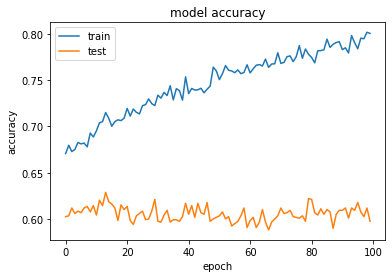

In [ ]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

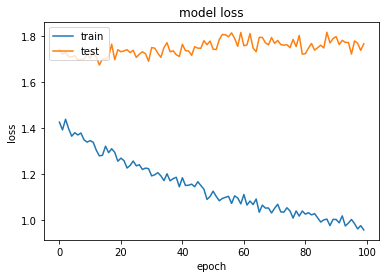

In [ ]:
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
history2 = model_final.fit(aug2.flow(x_train, y_train, batch_size=32), validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // 32, epochs=100, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1682: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
129/129 [==============================] - 81s 631ms/step - loss: 1.2734 - accuracy: 0.7079 - val_loss: 1.4595 - val_accuracy: 0.6804
Epoch 2/100
129/129 [==============================] - 79s 609ms/step - loss: 1.1839 - accuracy: 0.7318 - val_loss: 1.5238 - val_accuracy: 0.6669
Epoch 3/100
129/129 [==============================] - 79s 609ms/step - loss: 1.2114 - accuracy: 0.7196 - val_loss: 1.4605 - val_accuracy: 0.6809
Epoch 4/100
129/129 [==============================] - 79s 609ms/step - loss: 1.1807 - accuracy: 0.7347 - val_loss: 1.4425 - val_accuracy: 0.6826
Epoch 5/100
129/129 [==============================] - 79s 609ms/step - loss: 1.1767 - accuracy: 0.7323 - val_loss: 1.4532 - val_accuracy: 0.6849
Epoch 6/100
129/129 [==============================] - 79s 609ms/step - loss: 1.1581 - accuracy: 0.7481 - val_loss: 1.4697 - val_accuracy: 0.6776
Epoch 7/100
129/129 [==============================] - 79s 610ms/step - loss: 1.1352 - accuracy: 0.7449 - val_loss: 1.4663 -

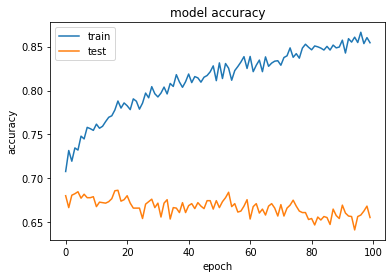

In [ ]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

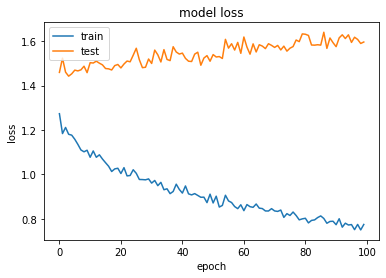

In [ ]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
history3 = model_final.fit(aug3.flow(x_train, y_train, batch_size=32), validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // 32, epochs=40, verbose=1)

Epoch 1/40
166/166 [==============================] - 81s 488ms/step - loss: 2.1054 - accuracy: 0.5009 - val_loss: 2.0697 - val_accuracy: 0.5338
Epoch 2/40
166/166 [==============================] - 81s 487ms/step - loss: 2.0735 - accuracy: 0.5043 - val_loss: 2.0719 - val_accuracy: 0.5253
Epoch 3/40
166/166 [==============================] - 81s 486ms/step - loss: 2.0111 - accuracy: 0.5184 - val_loss: 2.0739 - val_accuracy: 0.5253
Epoch 4/40
166/166 [==============================] - 81s 487ms/step - loss: 1.9670 - accuracy: 0.5326 - val_loss: 2.0475 - val_accuracy: 0.5304
Epoch 5/40
166/166 [==============================] - 81s 487ms/step - loss: 1.9656 - accuracy: 0.5304 - val_loss: 2.0632 - val_accuracy: 0.5304
Epoch 6/40
166/166 [==============================] - 81s 486ms/step - loss: 1.9429 - accuracy: 0.5434 - val_loss: 2.0447 - val_accuracy: 0.5490
Epoch 7/40
166/166 [==============================] - 81s 487ms/step - loss: 1.9298 - accuracy: 0.5387 - val_loss: 2.0330 - val_ac

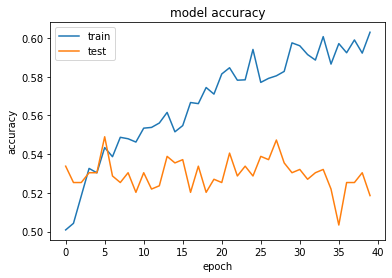

In [ ]:
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

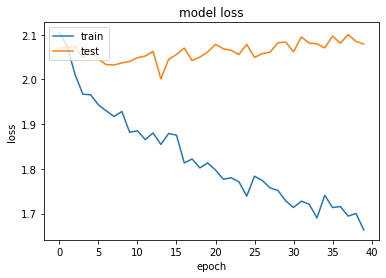

In [ ]:
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_image_paths = sorted(
    list(
        paths.list_images("/content/test/")
    )
)
print(">>> test image path =", test_image_paths)

>>> test image path = ['/content/test/TEST_00000.jpg', '/content/test/TEST_00001.jpg', '/content/test/TEST_00002.jpg', '/content/test/TEST_00003.jpg', '/content/test/TEST_00004.jpg', '/content/test/TEST_00005.jpg', '/content/test/TEST_00006.jpg', '/content/test/TEST_00007.jpg', '/content/test/TEST_00008.jpg', '/content/test/TEST_00009.jpg', '/content/test/TEST_00010.jpg', '/content/test/TEST_00011.jpg', '/content/test/TEST_00012.jpg', '/content/test/TEST_00013.jpg', '/content/test/TEST_00014.jpg', '/content/test/TEST_00015.jpg', '/content/test/TEST_00016.jpg', '/content/test/TEST_00017.jpg', '/content/test/TEST_00018.jpg', '/content/test/TEST_00019.jpg', '/content/test/TEST_00020.jpg', '/content/test/TEST_00021.jpg', '/content/test/TEST_00022.jpg', '/content/test/TEST_00023.jpg', '/content/test/TEST_00024.jpg', '/content/test/TEST_00025.jpg', '/content/test/TEST_00026.jpg', '/content/test/TEST_00027.jpg', '/content/test/TEST_00028.jpg', '/content/test/TEST_00029.jpg', '/content/test/TE

In [ ]:
print(">>> class index =",  mlb.classes_)
c = 0
result_list = []
for image_path in test_image_paths:
    c += 1
    test_image = cv2.imread(image_path)

    test_image = cv2.resize(
        test_image, (224, 224)
    )
    # cv2_imshow(test_image)

    # test_image = test_image.astype("float") / 255.0
    test_image = test_image.astype("float")
    test_image = np.expand_dims(test_image, axis=0)

    proba = model_final.predict(test_image)[0]
    # print(
    #     np.round(proba, 3)
    # )
    idx = np.argmax(proba)
    print(">>> predict class =", mlb.classes_[idx])
    result_list.append(mlb.classes_[idx])
    # if c == 10:
    #     print(result_list)
    #     break

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 51ms/step
>>> predict class = Peter Paul Rubens
1/1 [==============================] - 0s 54ms/step
>>> predict class = Giotto di Bondone
1/1 [==============================] - 0s 53ms/step
>>> predict class = Gustave Courbet
1/1 [==============================] - 0s 52ms/step
>>> predict class = Paul Gauguin
1/1 [==============================] - 0s 53ms/step
>>> predict class = Leonardo da Vinci
1/1 [==============================] - 0s 52ms/step
>>> predict class = Claude Monet
1/1 [==============================] - 0s 53ms/step
>>> predict class = Francisco Goya
1/1 [==============================] - 0s 53ms/step
>>> predict class = Pierre-Auguste Renoir
1/1 [==============================] - 0s 51ms/step
>>> predict class = Albrecht Du rer
1/1 [==============================] - 0s 52ms/step
>>> predict class = Diego Rivera
1/1 [==============================] - 0s 53ms/step
>>> predict class = Titian
1/1

In [ ]:
#테스트 csv 파일 불러오기
resultfile = pd.read_csv('/content/drive/MyDrive/dacon_art/result.csv')

In [ ]:
#결과 파일 생성
f = open('/content/result_1028_3.csv', 'w')
f.write('id,artist' '\n')

for id, p in zip(resultfile['id'], result_list): 
    f.write(f'{id},{p}\n')
f.close()